## Part 2: Parameter estimation in a state-space model

In this exercise, we shall develop models to predict the temperature evolution in a transformer station in a DSO (distribution system operator, distributing electricity from high-voltage grid out to the end consumer) grid. Transformer stations are vital to the electricity transportation system, and having the operate optimally is advantagous.
A brief introduction to a transformer station. Roughly speaking, a transformer station receives electricity at a high voltage and sends out electricity at a lower voltage. In this process, some energy is lost in the transformer and converted into heat. 

DSO transformer stations typically use oil for cooling (like water cooling, just with oil). 
The highest temperature inside the transformer station needs to be below a given threshold in order to limit the speed of degradation of the transformer station and to avoid it catching fire. In this data, a good approximation to this temperature is measured. We would now like a model that is able to predict this temperature.

### 2.1

In [1]:
import pandas as pd

df = pd.read_csv('./transformer_data.csv')
df.describe()

time           Y          Ta           S           I
count  168.000000  168.000000  168.000000  168.000000  168.000000
mean    84.500000   27.650595   10.023115  214.432540   18.179092
std     48.641546    5.455816    2.916687  259.451647    3.662521
min      1.000000   19.828583    4.516667    0.000000   14.386027
25%     42.750000   23.246383    7.866667    0.000000   15.635851
50%     84.500000   26.066717    9.750000   65.416667   16.367102
75%    126.250000   32.201554   12.000000  410.250000   21.212430
max    168.000000   38.923850   17.466667  755.833333   25.362786

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

PARAMETERS = {"col":["Y", "Ta", "S", "I"], "z_col":["Y_z", "Ta_z", "S_z", "I_z"], "tex_col": ["Y_t", "T_{a, t}", "\Phi_{s,t}", "\Phi_{I,t}"], "col_unit":["◦C", "◦C", "W / m^2", "kA"], "col_name":["Transformer Station Temperature", "Outdoor Air Temperature", "Horizontal Global Solar Radiation", "Load on the Transformer Station"]}
for col in PARAMETERS["col"]:
    df[col+"_z"] = (df[col]-df[col].mean())/df[col].std()

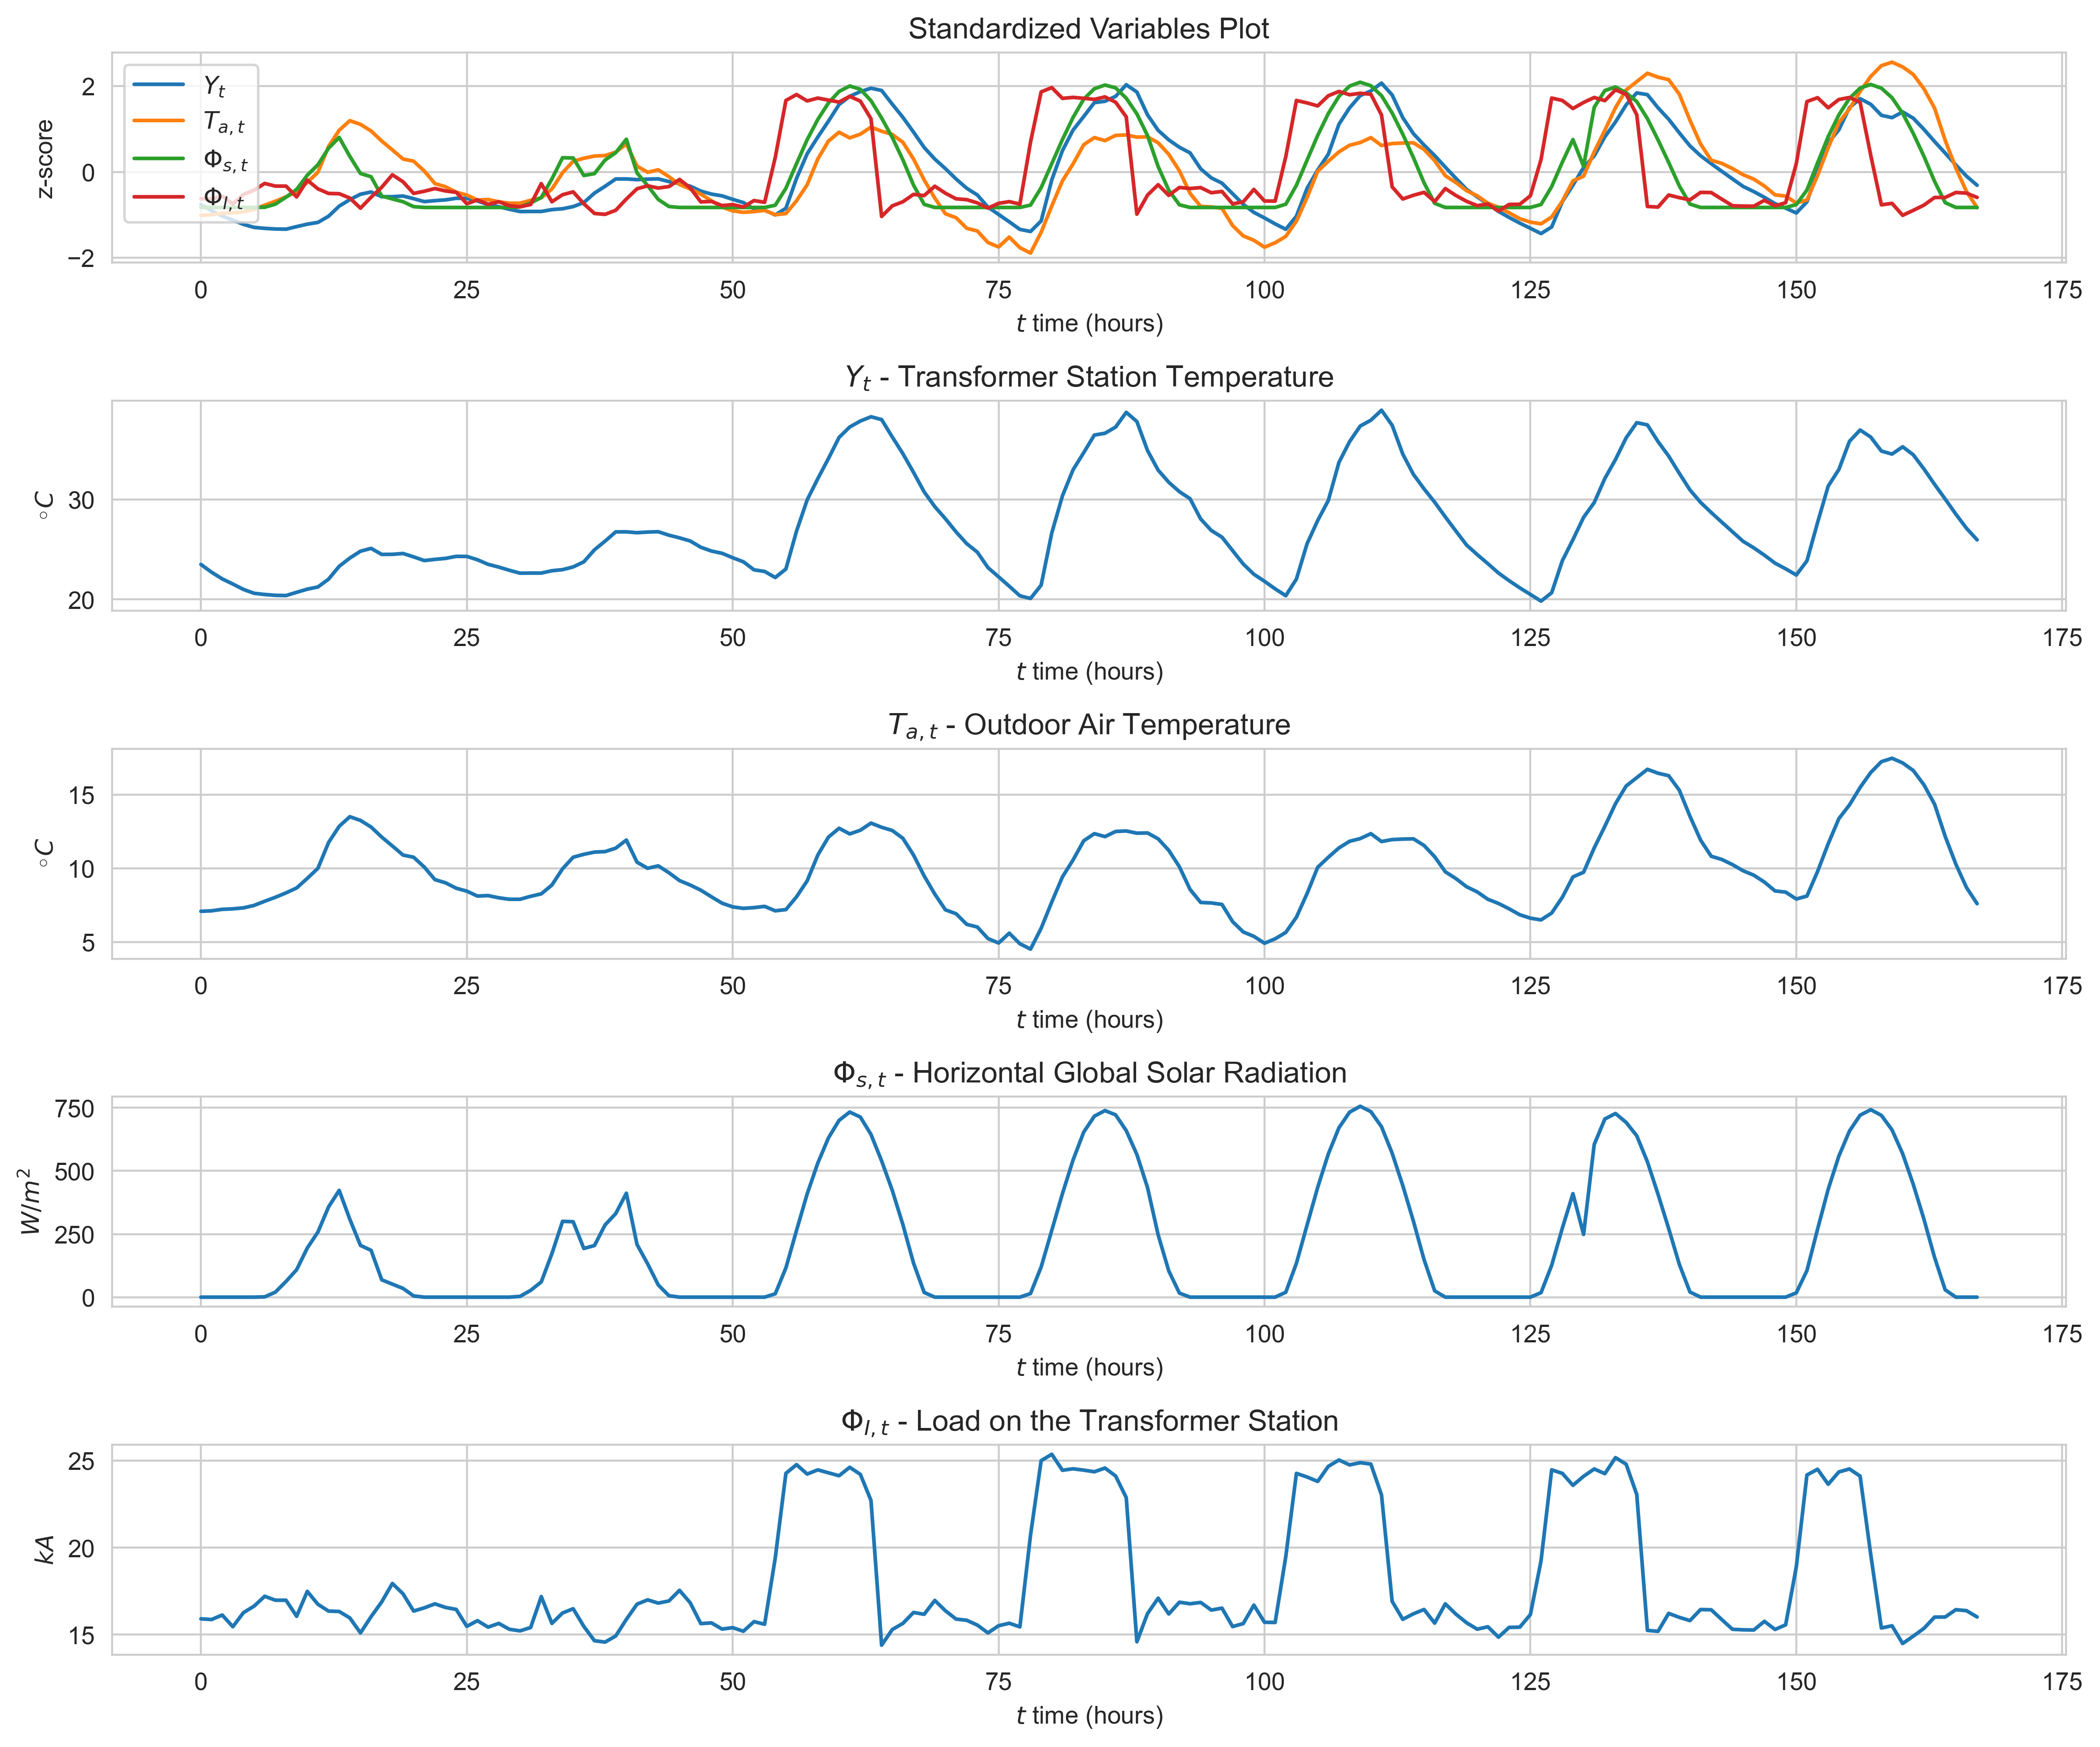

In [76]:
plt.figure(figsize=(12,10), dpi=400)

plt.subplot(5,1,1)
plt.title("Standardized Variables Plot")
for param, tex_param in zip(PARAMETERS["z_col"], PARAMETERS["tex_col"]):
    plt.plot(df[param], label=f"${tex_param}$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("z-score")
plt.legend()

for i, param in enumerate(PARAMETERS["col"]):
    plt.subplot(5,1,i+2)
    plt.title(f'${PARAMETERS["tex_col"][i]}$ - {PARAMETERS["col_name"][i]}')
    plt.plot(df[param])
    plt.xlabel('$t$ time (hours)')
    plt.ylabel(f'${PARAMETERS["col_unit"][i]}$')

plt.tight_layout()

*Comment:*

There is very clearly a seasonality for day/night-cycles in all variables. 
The solar radiation $\Phi_{s,t}$ drops to $0$ during the night, which the load $\Phi_{I,t}$ mirrors almost exactly. It has a slightly quicker drop, once the sun is setting and during the peaks it displays a wiggle, which suggests some sort of load controller or a load maximum with excess being discharged. Lower peaks or crumples in the radiation curve could be explained by cloud cover.
A curious thing to notice, is that the load on the transformer $\Phi_{I,t}$ appears to have a quicker attack-time to rise, than the solar radiation $\Phi_{s,t}$. Intuitively, we would expect the solar radiation to lead and load to lag.
The $Y_t$ temperature follows $\Phi_{s,t}$ showing some cool-down period, once solar radiation dropped, hence a slower decay in temperature.
Outdoor temperature $T_{a,t}$ not only follows the solar radiation, hence daily 24h seasonality, but also exhibits a longer period seasonality, which could be climate and wheather effects.

Overall, we can actually deduce a lot from just outdoor temperature and solar radiation cycles, especially the uninterrupted (unclouded) ones.
When inspecting the graph, we can deduce about 17h of daylight, which excludes locations betwee $\approx \pm 54$ degrees N/S. In the southern-hemisphere there is only 'Tierra de Fuego' the southern cape of Latin America that is still land-mass, but it does not match the temperature profile (as even in summer, for the long daylight hours, it has max. temperatures of about 8 degrees Celsius). One could possible match the outdoor temperature with weather data to deduce a more accurate location.

### 2.2

**Model:**

$$
X_{t+1} = a X_t + B u_t + e_{1,t} \\
Y_t = c X_t + e_{2,t}
$$

* $u_t = [T_{a,t}, \Phi_{s,t}, \Phi_{I,t}]^\top \in \mathbb{R}^{1\times3}$
* $a \in \mathbb{R}, B \in \mathbb{R}^{1\times3}, c \in \mathbb{R}, D \in \mathbb{R}^{1\times3} = 0$ 
* $e_{1,t} \in \mathbb{R}, e_{2,t} \in \mathbb{R}$
* $\Rightarrow X_t \in \mathbb{R}$

For some reason, sigma1 and sigma2 are driven to the lower boundry of the optimizer. Is the system thus just noise free?

In [8]:
import numpy as np
from project.ssm import kalman_loglik, estimate_ssm_parameters, flatten_params

# generic formulation with the right shapes
A_shape = (1, 1)
B_shape = (1, 3)
C_shape = (1, 1)
D_shape = (1, 3)
Q_shape = (1, 1)
R_shape = (1, 1)
x0_shape = (1,)

start_matrices = (
    np.eye(1)*0.8,                  # A - 1
    np.array([[0.05, 0.1, 0.1]]),   # B - 3
    np.ones((1, 1)) * (0.1),        # C - 1
    np.zeros((1, 3)),               # D - 3
    np.eye(1) * np.log(2),          # Q - 1
    np.eye(1) * np.log(2),          # R - 1
    np.array([20.0, 20.0])          # x0 - 2
)

start_flat = flatten_params(*start_matrices)
bounds = [(-2, 2)] * 5 + [(0, 0)] * 3 + [(1e-3,3)] * 2 + [(18,23)] * 2 # adjust bounds as needed

# estimate (including the starting value)
result, (A_est, B_est, C_est, D_est, Q_est, R_est, x0_est) = estimate_ssm_parameters(
    kalman_loglik=kalman_loglik,
    Y=df["Y"].values,
    u_df=df[["Ta", "S", "I"]],
    A_shape=A_shape, B_shape=B_shape, C_shape=C_shape, D_shape=D_shape,
    Q_shape=Q_shape, R_shape=R_shape, x0_shape=x0_shape,
    start=start_flat,
    bounds=bounds
)


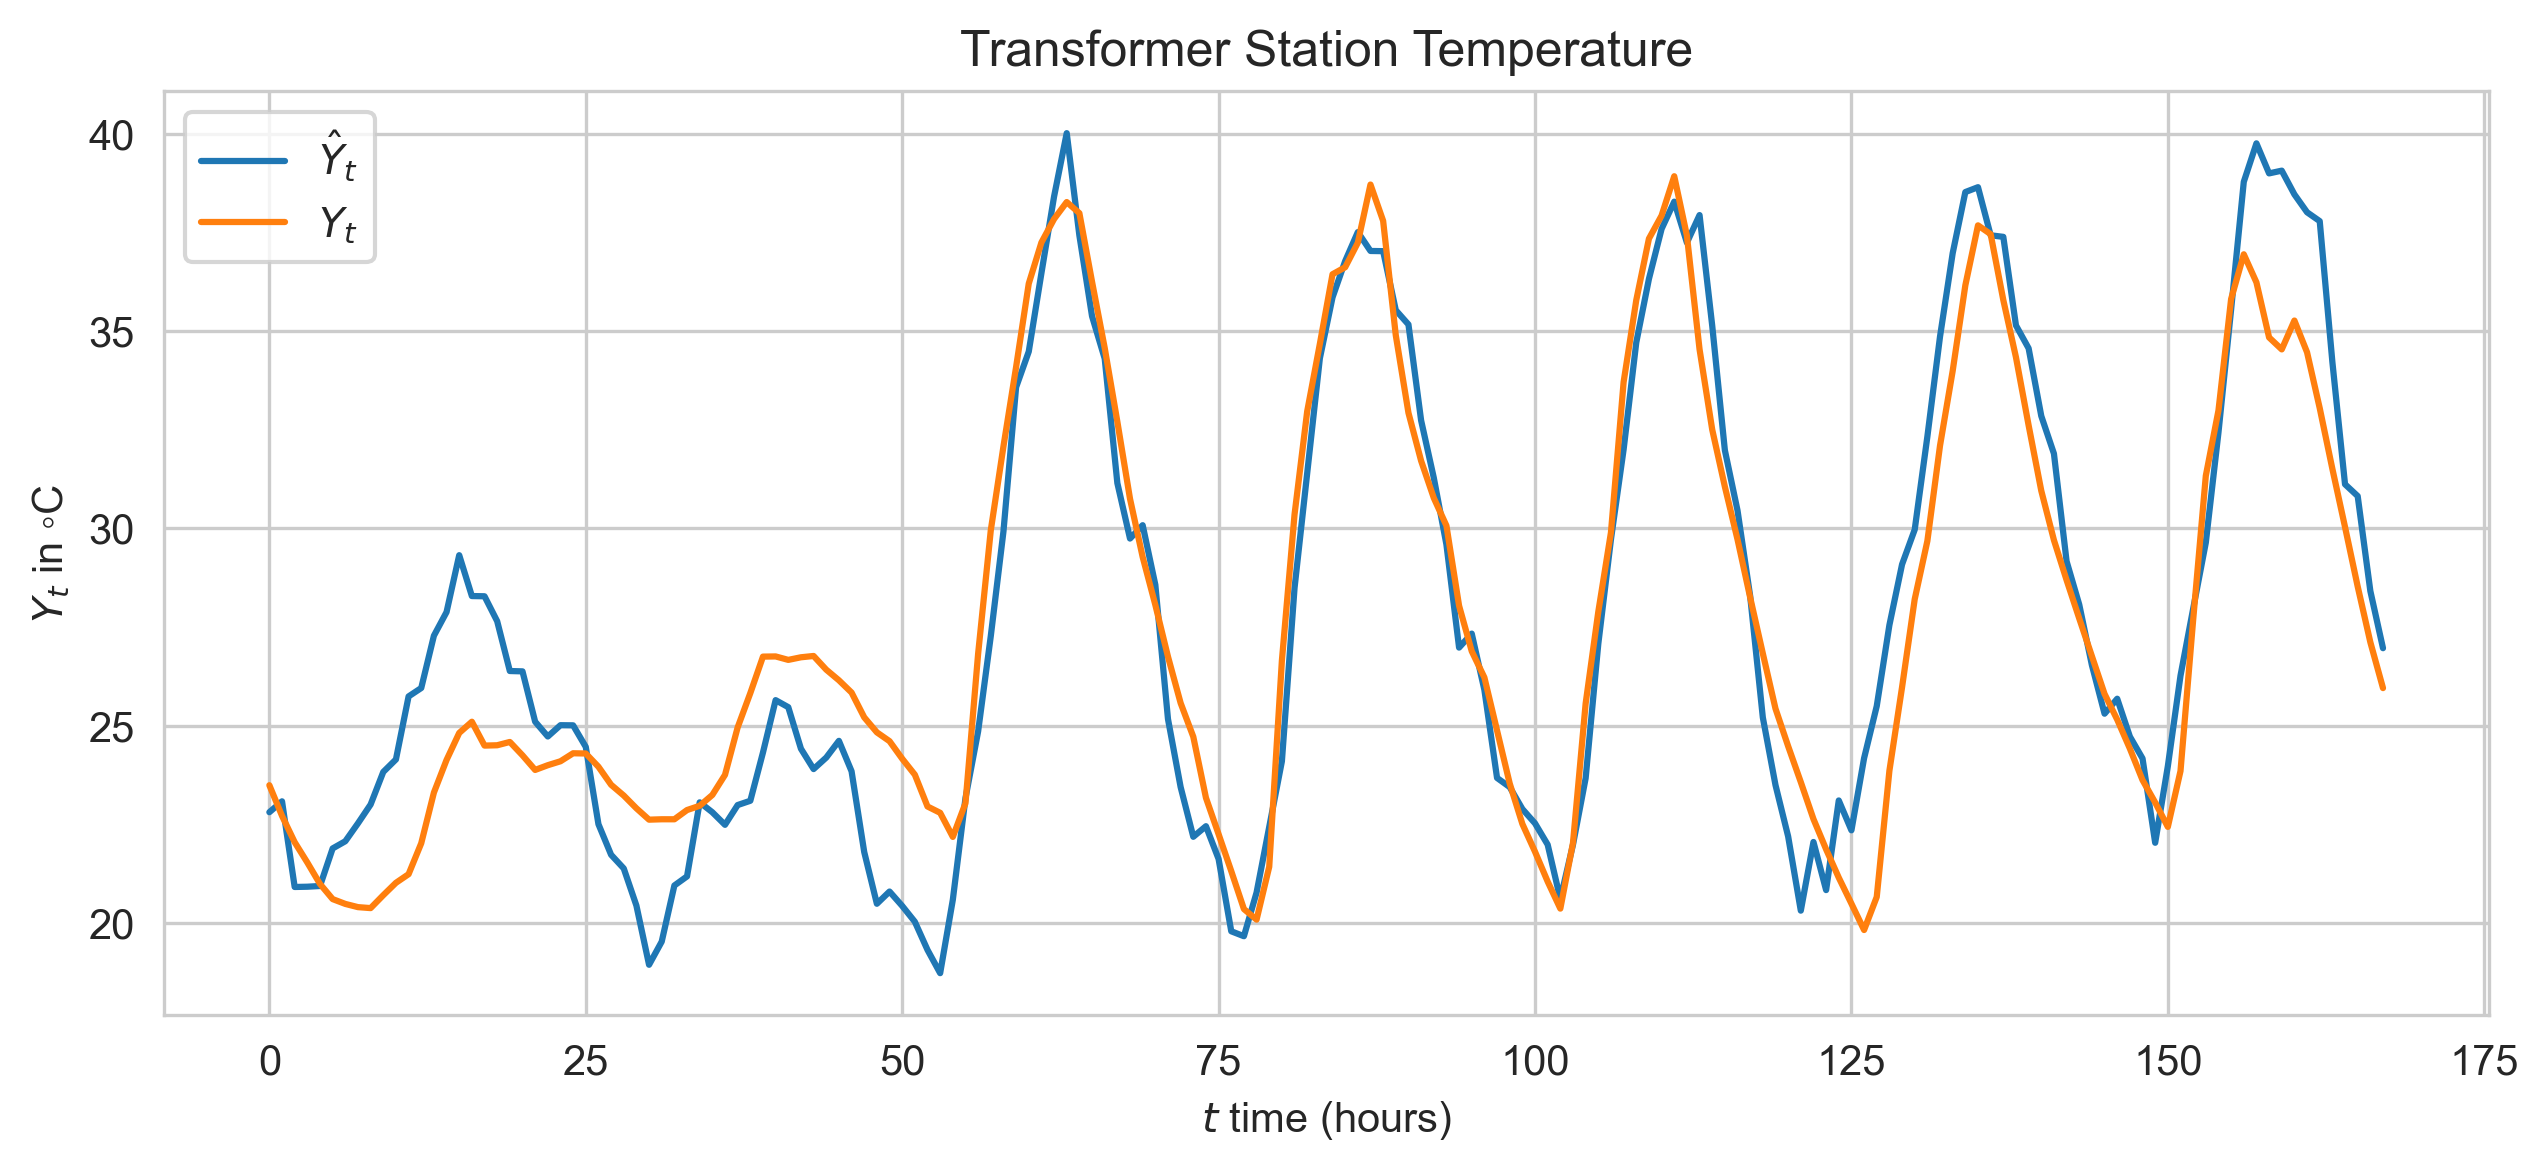

In [9]:
from project.ssm import simulate_ssm
from project.utils import plot_obervations

y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)
plot_obervations(y, df)

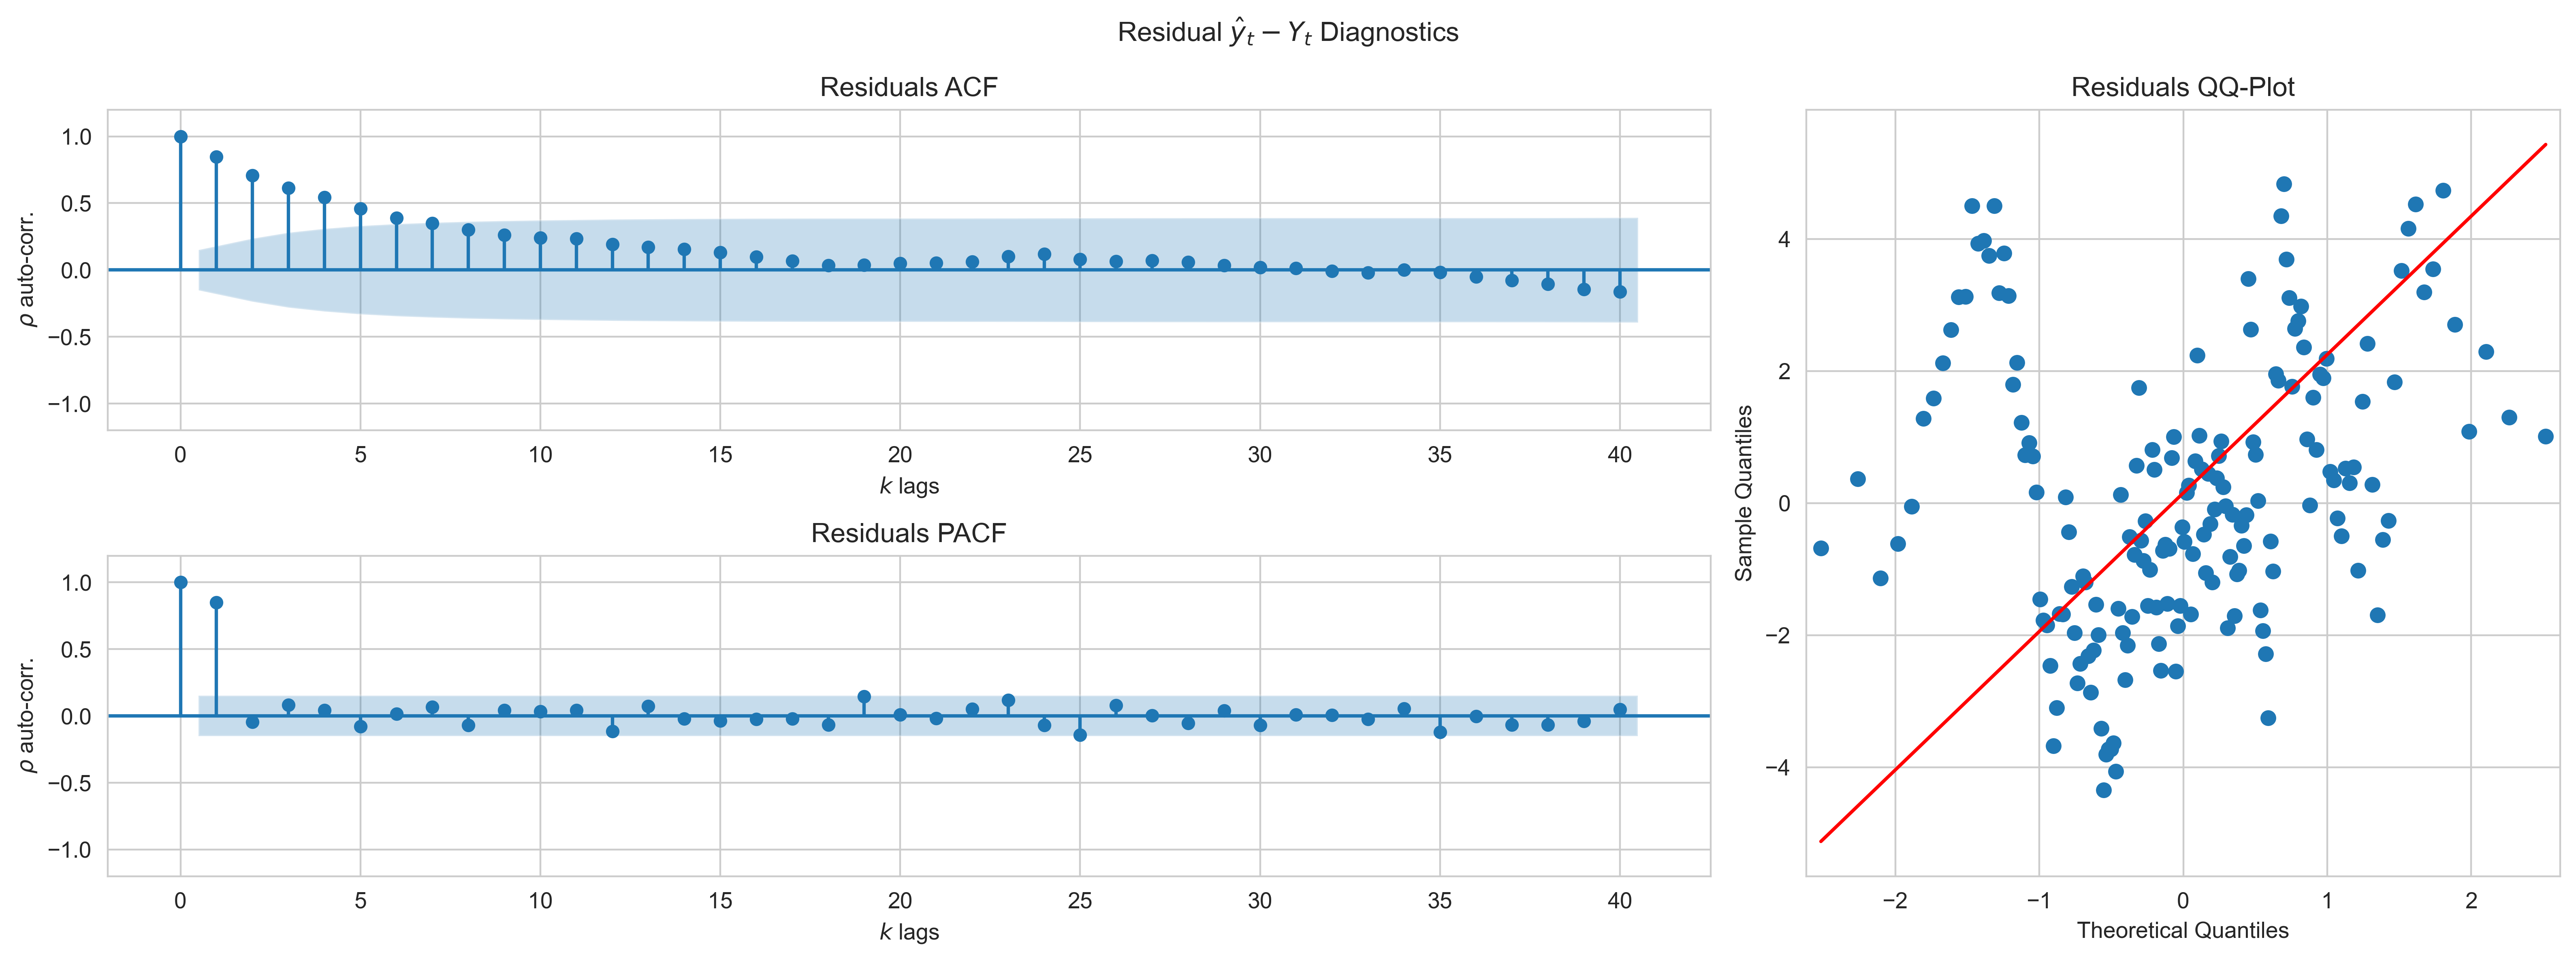

In [11]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"].values.reshape(-1,1)
residuals.shape
plot_residual_diagnostics(residuals)

Okay, something the this implementation is clearly not working.

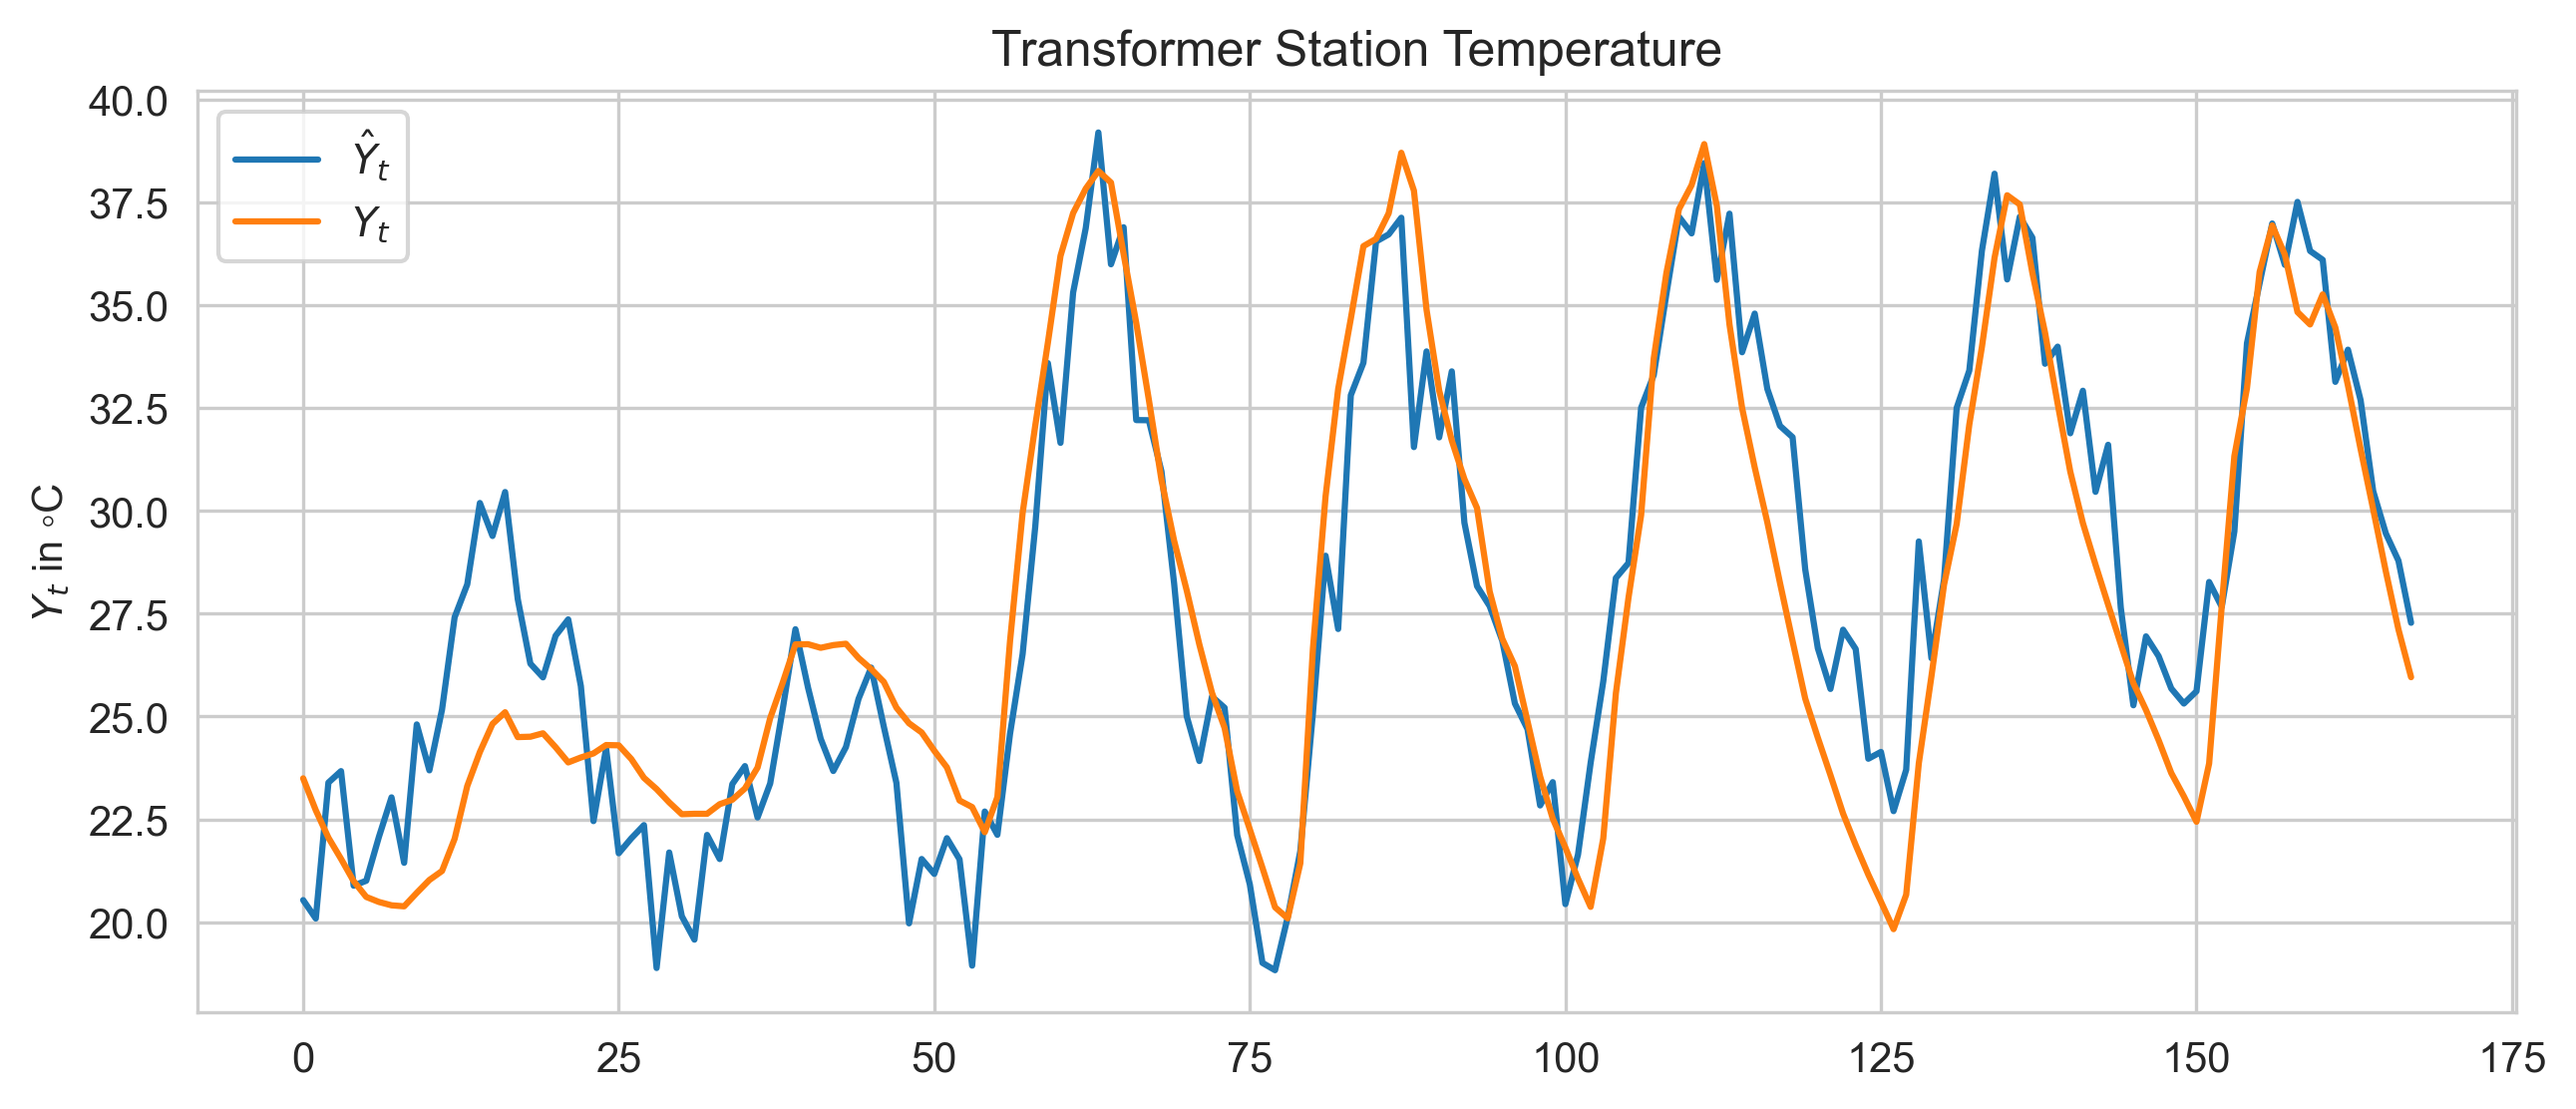

In [1]:
from project.ssm import estimate_1d_state_space, simulate_from_model_1d
from project.utils import plot_obervations
import pandas as pd
import numpy as np

df = pd.read_csv("./transformer_data.csv")

# adheres to assignment4 tip; params in [-1,1], x0=20, w/o x0 estimation
res = estimate_1d_state_space(df)
y, x = simulate_from_model_1d(res.x, df)

plot_obervations(y, df)

In [2]:
# [a, B1, B2, B3, c, sigma1, sigma2]
res.x

array([0.79060518, 0.13127928, 0.00310831, 0.25236025, 0.88627504,
       0.001     , 0.001     ])

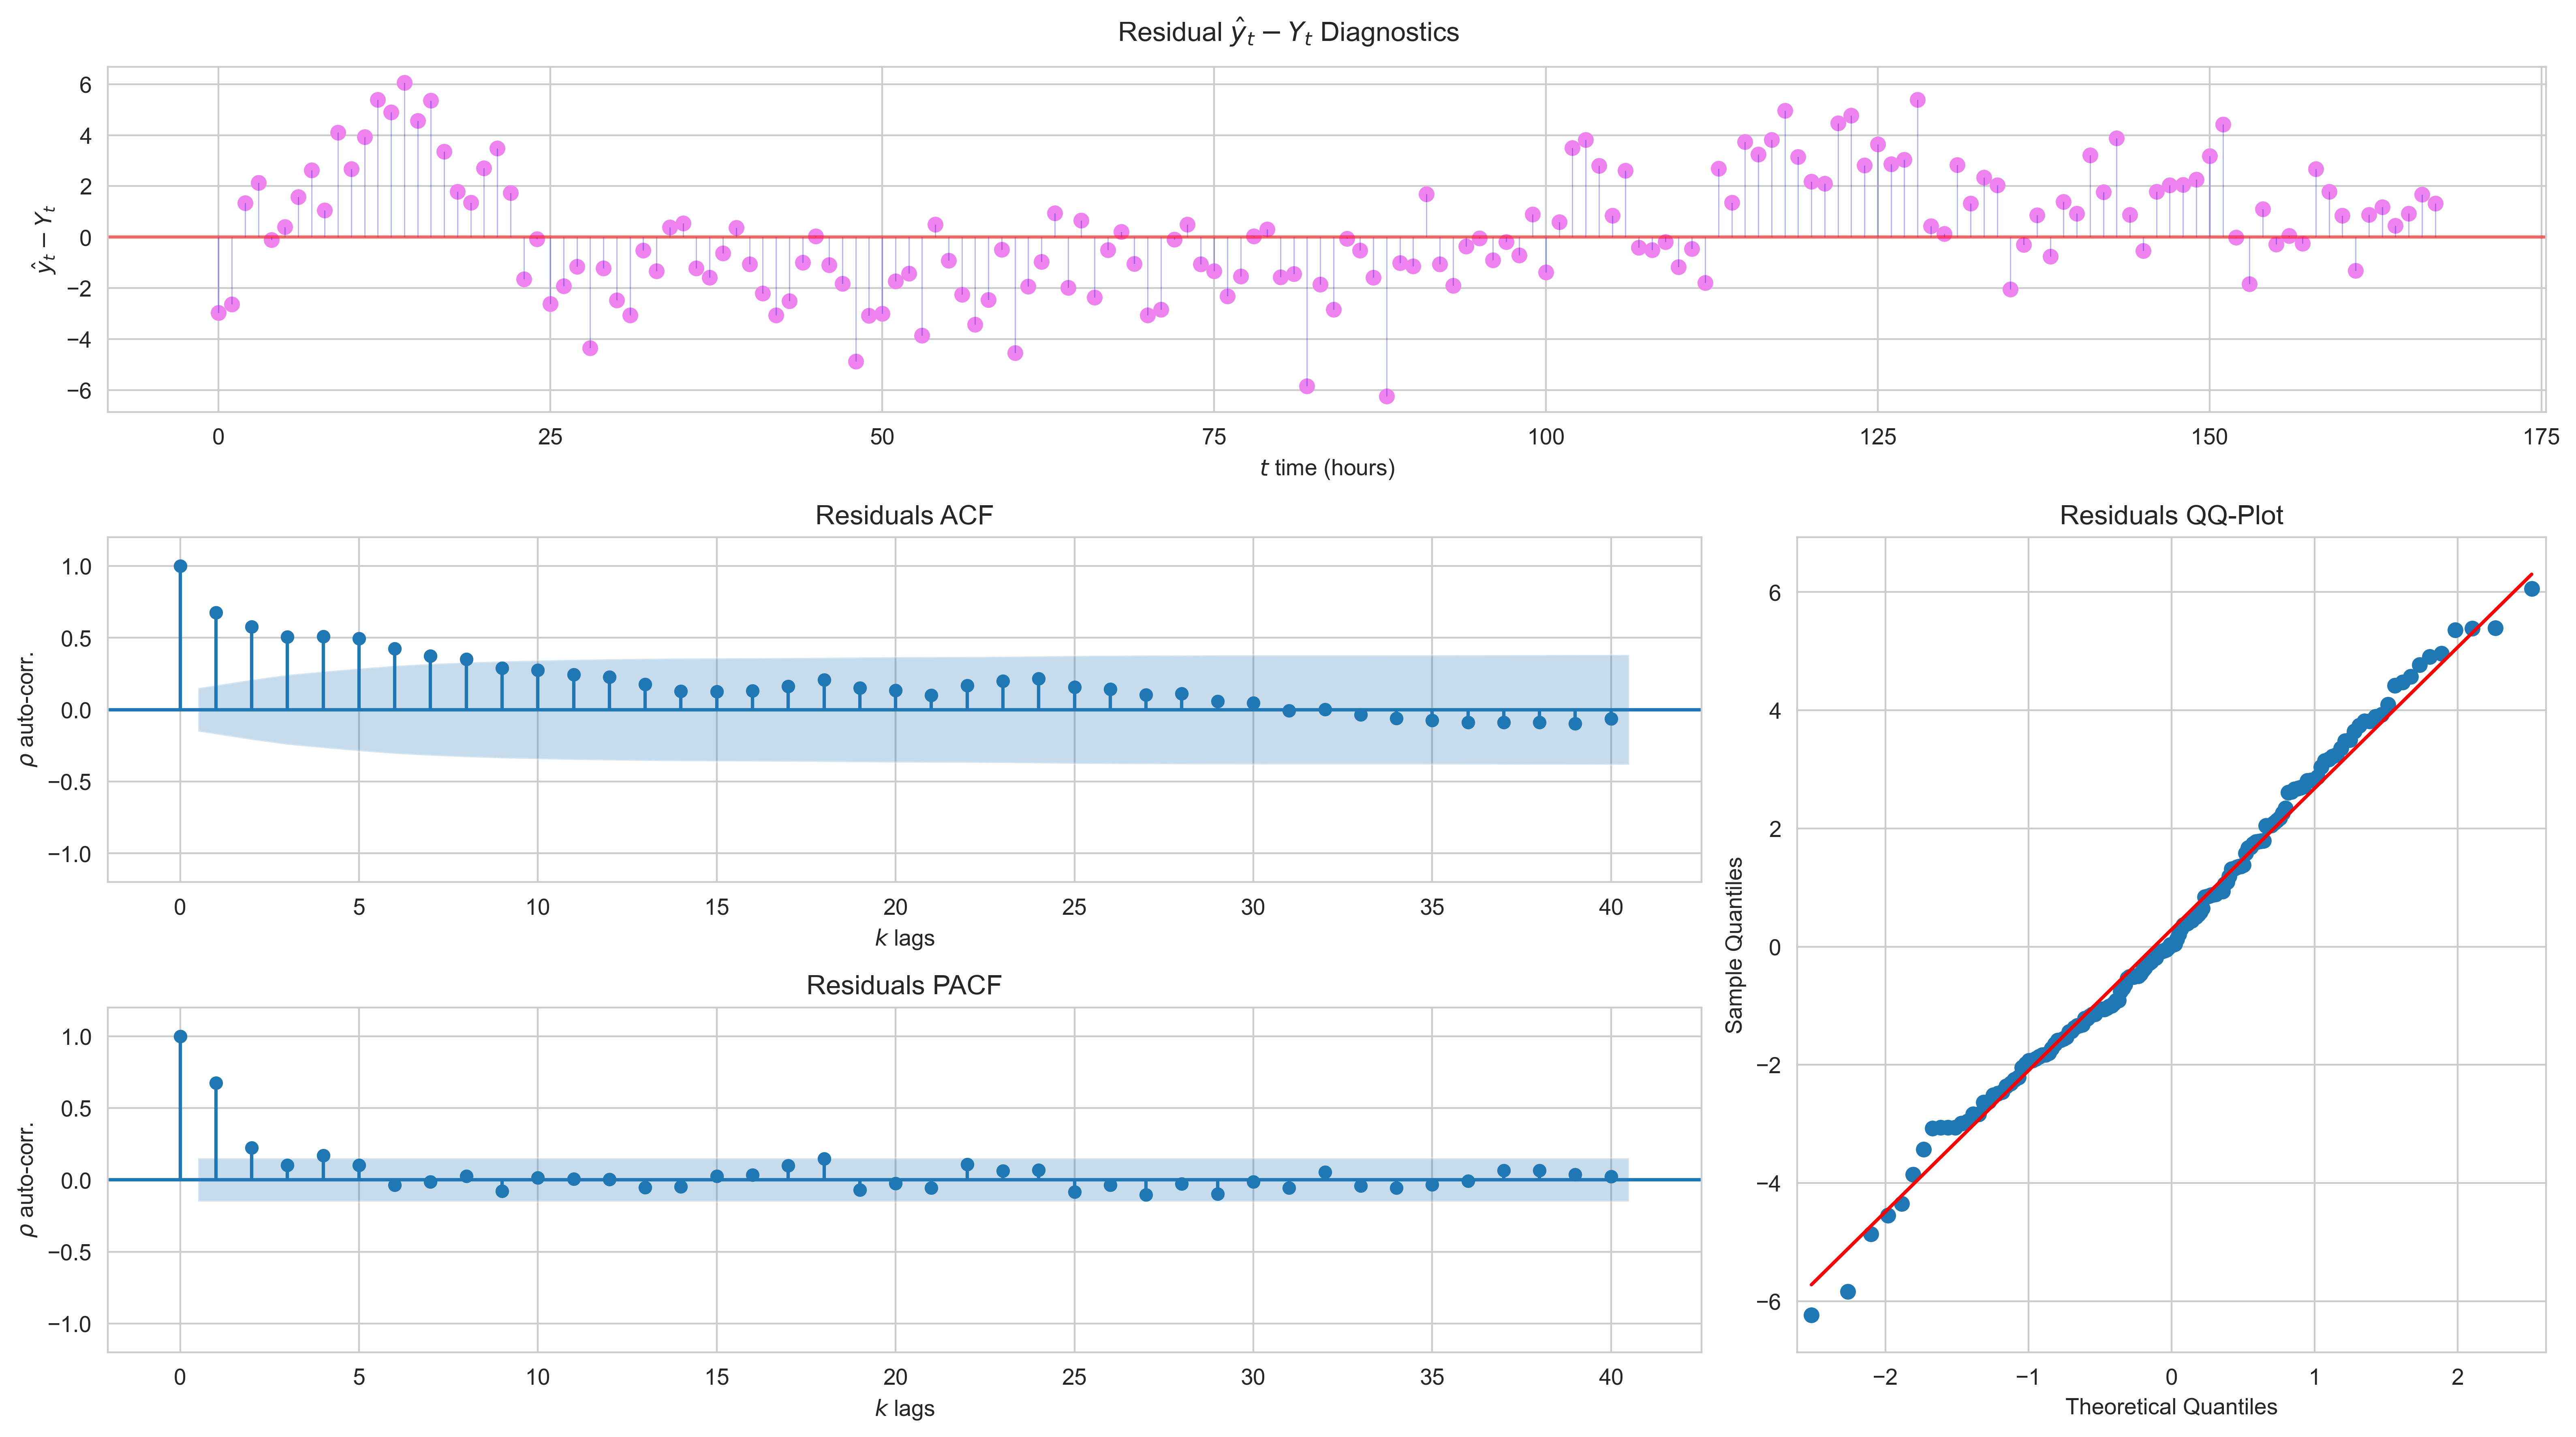

In [3]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"].values
plot_residual_diagnostics(residuals)

In [15]:
from project.utils import compute_aic_bic
from project.ssm import kalman_loglik_1d

loglik = kalman_loglik_1d(res.x, df)
compute_aic_bic(-loglik, len(res.x), len(y))

(495.15131437017845, 517.0190622260013)

Okay, we'll choose this implementation without optimizing for $X_0$ or $D$.

### 2.3

**2-dim state-space model:**

$$
\mathbf{X}_{t+1} = \mathbf{A} \mathbf{X}_t + \mathbf{B} \mathbf{u}_t + \mathbf{e}_{1,t} \\
Y_t = \mathbf{C} \mathbf{X}_t + \mathbf{D} \mathbf{u}_t + e_{2,t}
$$

* $\mathbf{X}_t \in \mathbb{R}^2$, $\mathbf{u}_t \in \mathbb{R}^3$
* $\mathbf{A} \in \mathbb{R}^{2\times2}, \mathbf{B} \in \mathbb{R}^{2\times3}, \mathbf{C} \in \mathbb{R}^{1\times2}, \mathbf{D} \in \mathbb{R}^{1\times3}=\mathbf{0}$

In [13]:
from project.ssm import kalman_loglik, estimate_ssm_parameters, flatten_params
import numpy as np
import pandas as pd

df = pd.read_csv("./transformer_data.csv")

# generic formulation with the right shapes
A_shape = (2, 2)
B_shape = (2, 3)
C_shape = (1, 2)
D_shape = (1, 3)
Q_shape = (2, 2)
R_shape = (1, 1)
x0_shape = (2,)

start_matrices = (
    # np.eye(2),                        # A - 4
    np.array([[-0.3, -0.1],              # A - 4
            [0.1, 0.5]]),  
    #np.array([[0.8, -0.3],              # A - 4
    #        [0.7, 0.9]]),  
    np.random.rand(2, 3) * 0.2,        # B - 6
    #np.array([[-1.7, 1.8, -1.2],        # B - 6
    #        [0.9, -0.5, 0.8]]),  
    np.ones((1, 2))*0.5,                # C - 2
    np.zeros((1, 3)),                   # D - 3
    np.eye(2) * 0.5,                    # Q - 4
    np.array([[1.0]]),                  # R - 1
    np.array([20.0, 20.0])              # x0 - 2
)

start_flat = flatten_params(*start_matrices)
bounds = [(-5, 5)] * 12 + [(0, 0)] * 3 + [(1e-3,2)] * 5 + [(15,25)] * 2 # adjust bounds as needed

# estimate (including the starting value)
result, (A_est, B_est, C_est, D_est, Q_est, R_est, x0_est) = estimate_ssm_parameters(
    kalman_loglik=kalman_loglik,
    Y=df["Y"].values,
    u_df=df[["Ta", "S", "I"]],
    A_shape=A_shape, B_shape=B_shape, C_shape=C_shape, D_shape=D_shape,
    Q_shape=Q_shape, R_shape=R_shape, x0_shape=x0_shape,
    start=start_flat,
    bounds=bounds
)


Retry 1 failed, retrying...


/Users/yunis99wirkus/Library/Mobile Documents/com~apple~CloudDocs/CodingScripts/PythonScripts/StudiesDK/TimeSeriesAnalysis/DTU-02613-TimeSeries_Assignment1/Assignment4/project/ssm.py:40: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  w_t = rng.multivariate_normal(np.zeros(n), Q)


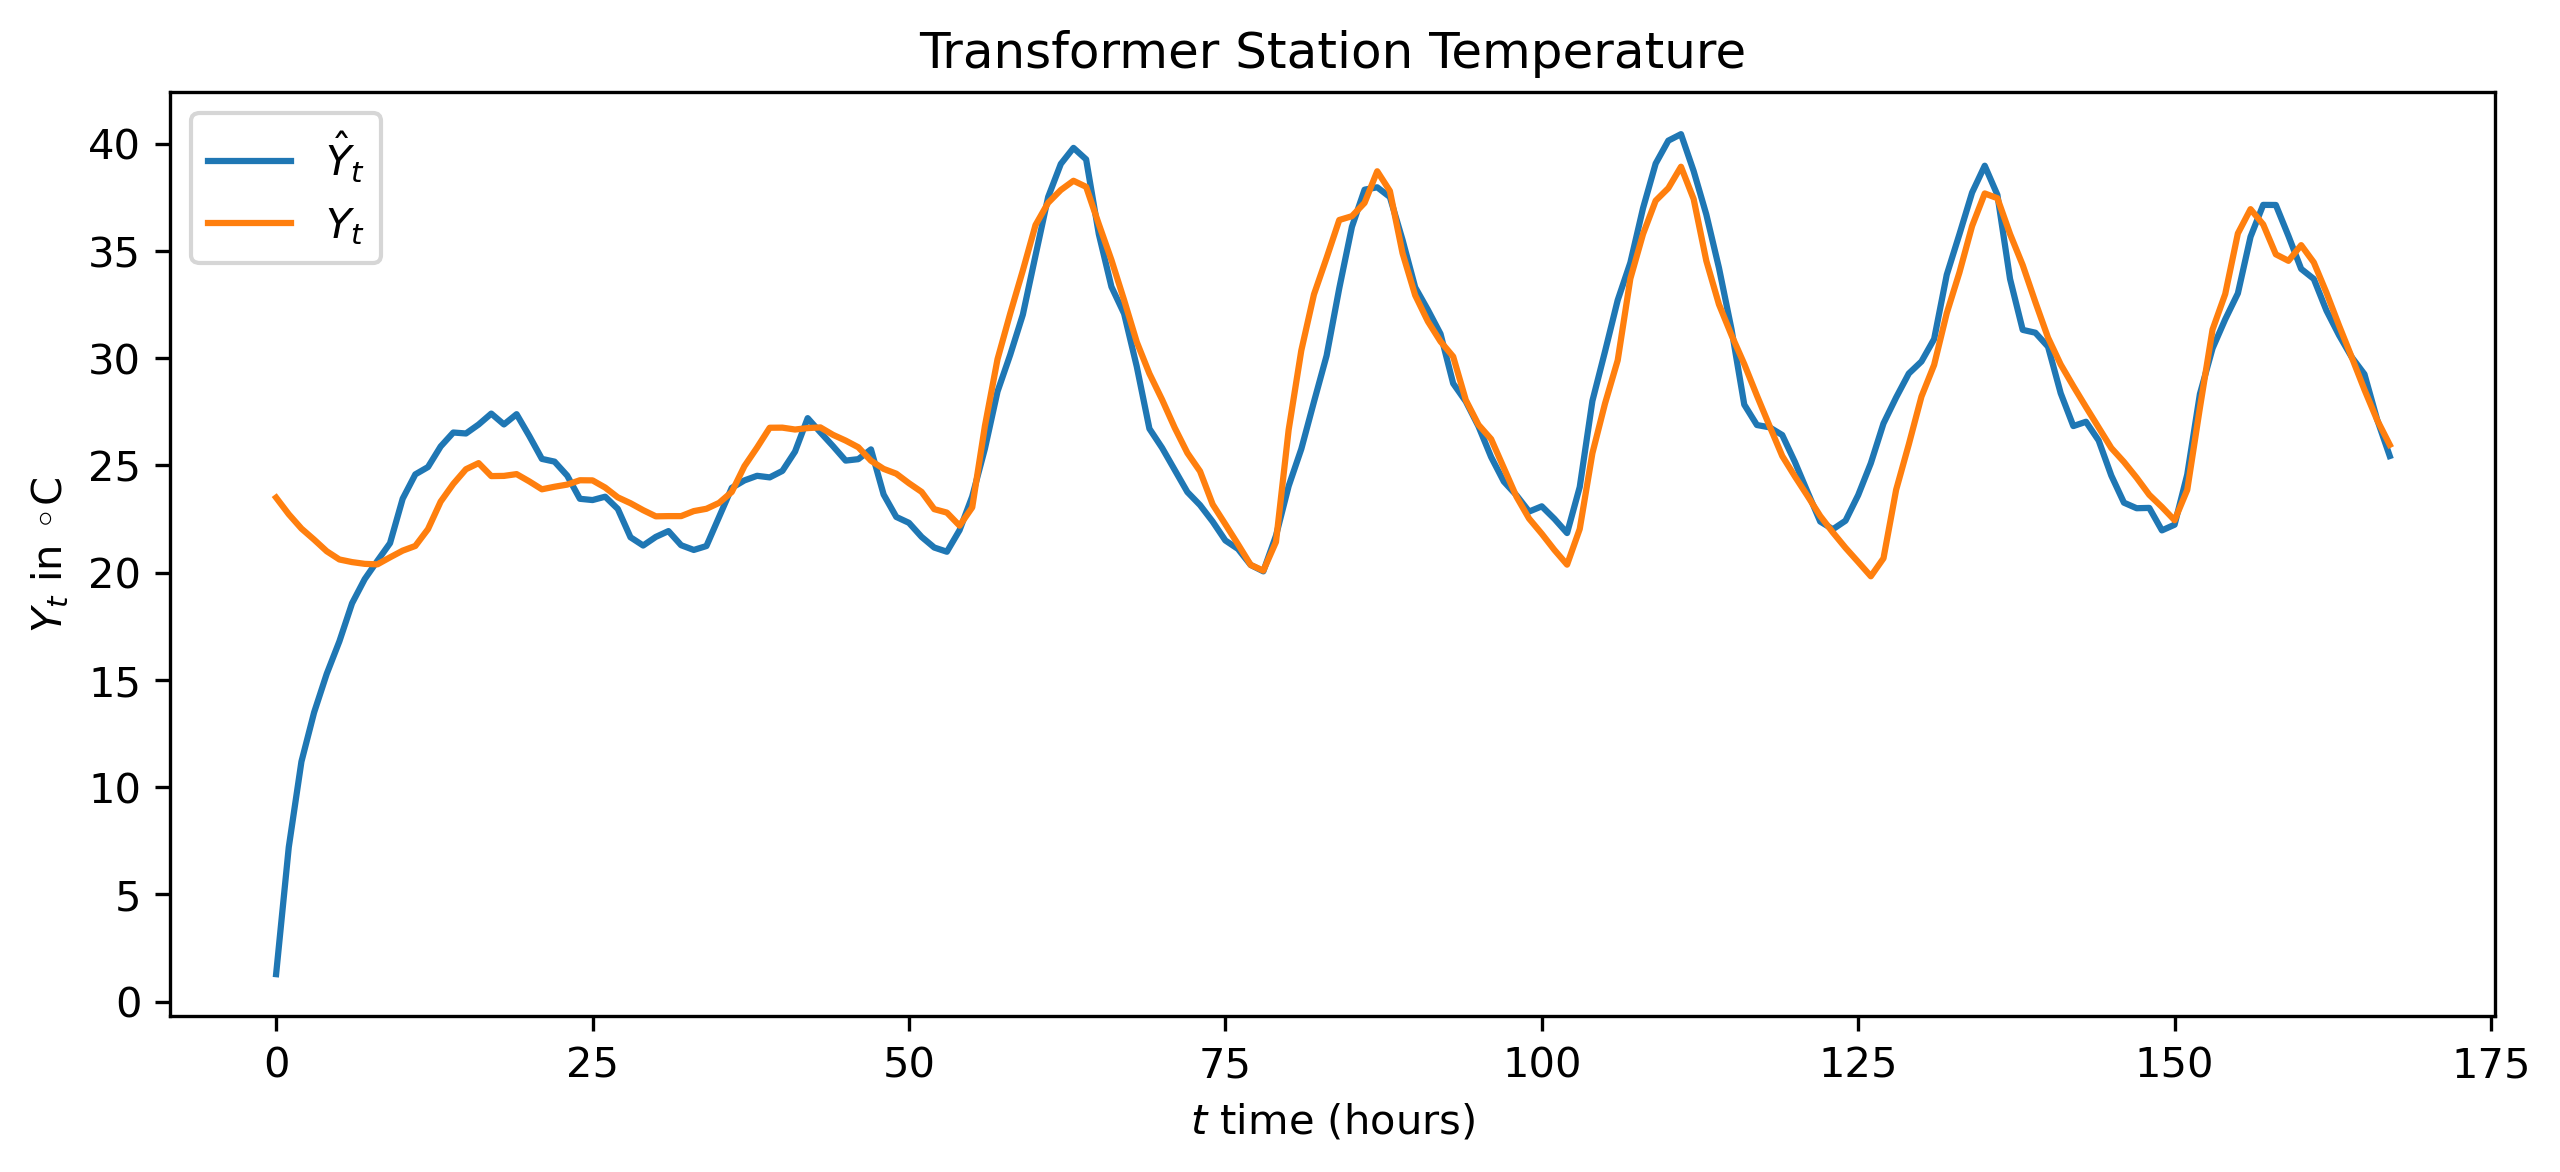

In [14]:
from project.ssm import simulate_ssm
from project.utils import plot_obervations

y, x = simulate_ssm(A_est, B_est, C_est, D_est, Q_est, R_est, df[["Ta", "S", "I"]].values, x0_est)
plot_obervations(y, df)

In [15]:
print(A_est, B_est, C_est, D_est, Q_est, R_est, x0_est)

[[-0.40249804 -0.65411212]
 [ 0.69939654  1.1374673 ]] [[ 0.34392731  0.00122079  0.41139555]
 [-0.00819203  0.00250865  0.15976755]] [[-0.04965919  0.57061181]] [[0. 0. 0.]] [[0.27048338 0.26326993]
 [0.05746223 0.85368195]] [[0.00196996]] [20.00435166 20.04996446]


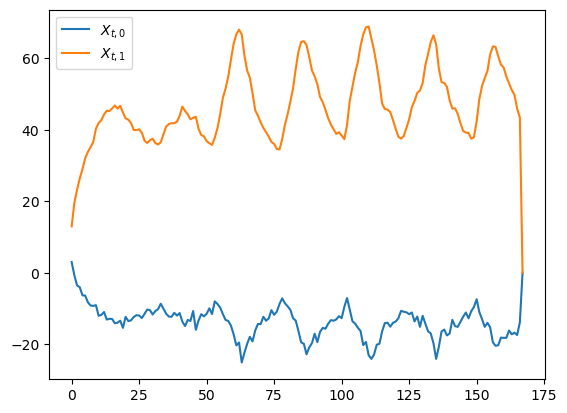

In [16]:
import matplotlib.pyplot as plt
plt.plot(x[:,0], label="$X_{t,0}$")
plt.plot(x[:,1], label="$X_{t,1}$")
plt.legend()

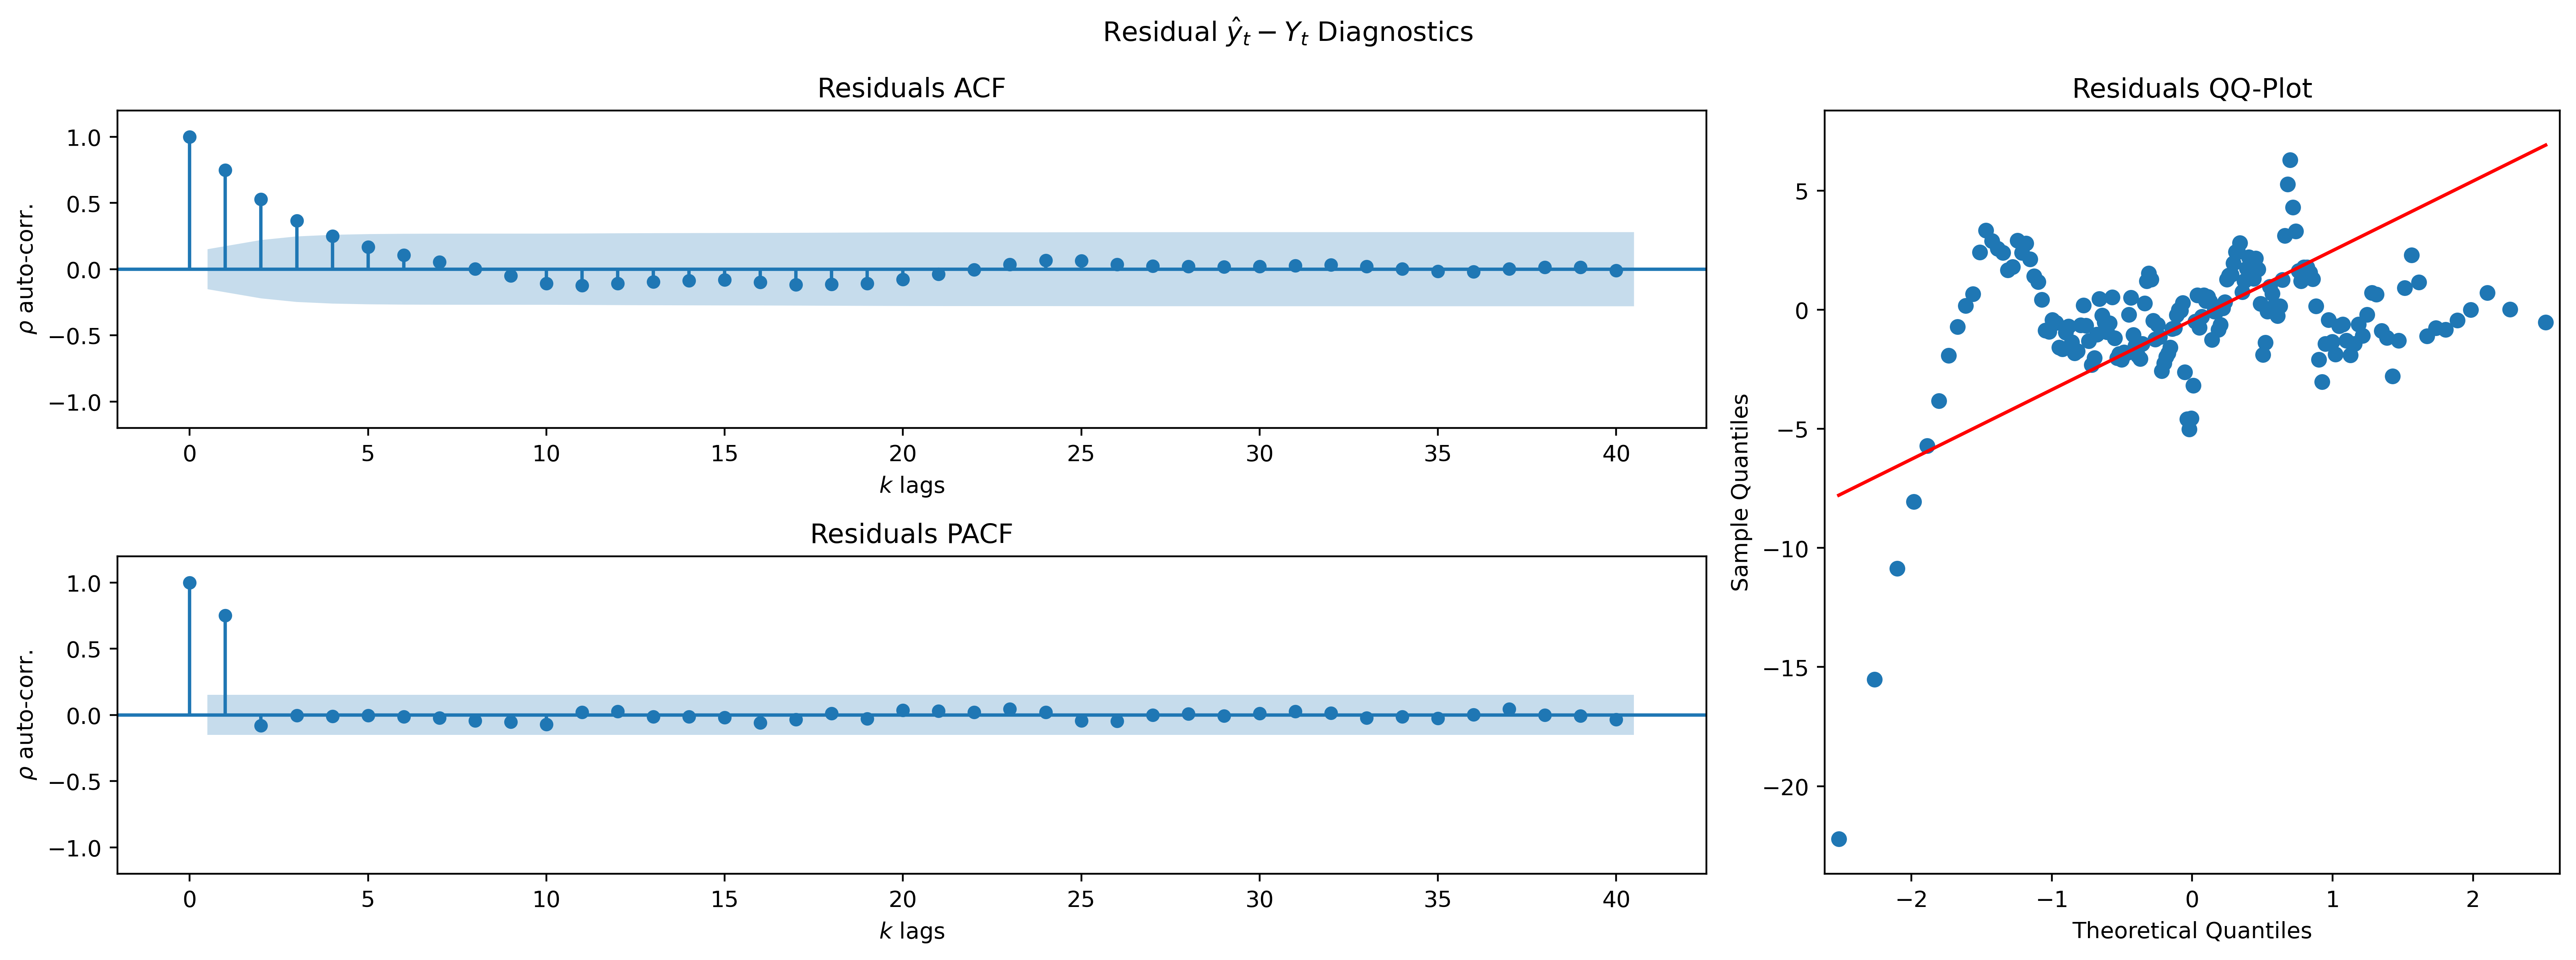

In [17]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"].values.reshape(-1,1)
plot_residual_diagnostics(residuals)

The results are extremely volatile towards initial conditions $X_0$ and the hidden states $X_t$ are not at all uniquely determined!

Why do the residual plots look so shit for the n-D implementation?
- presumably because the optimiser has $D$ as a matrix to account for in the optimization, alas constrained to 0, it makes the optimisation landscape more complicated and error-prone

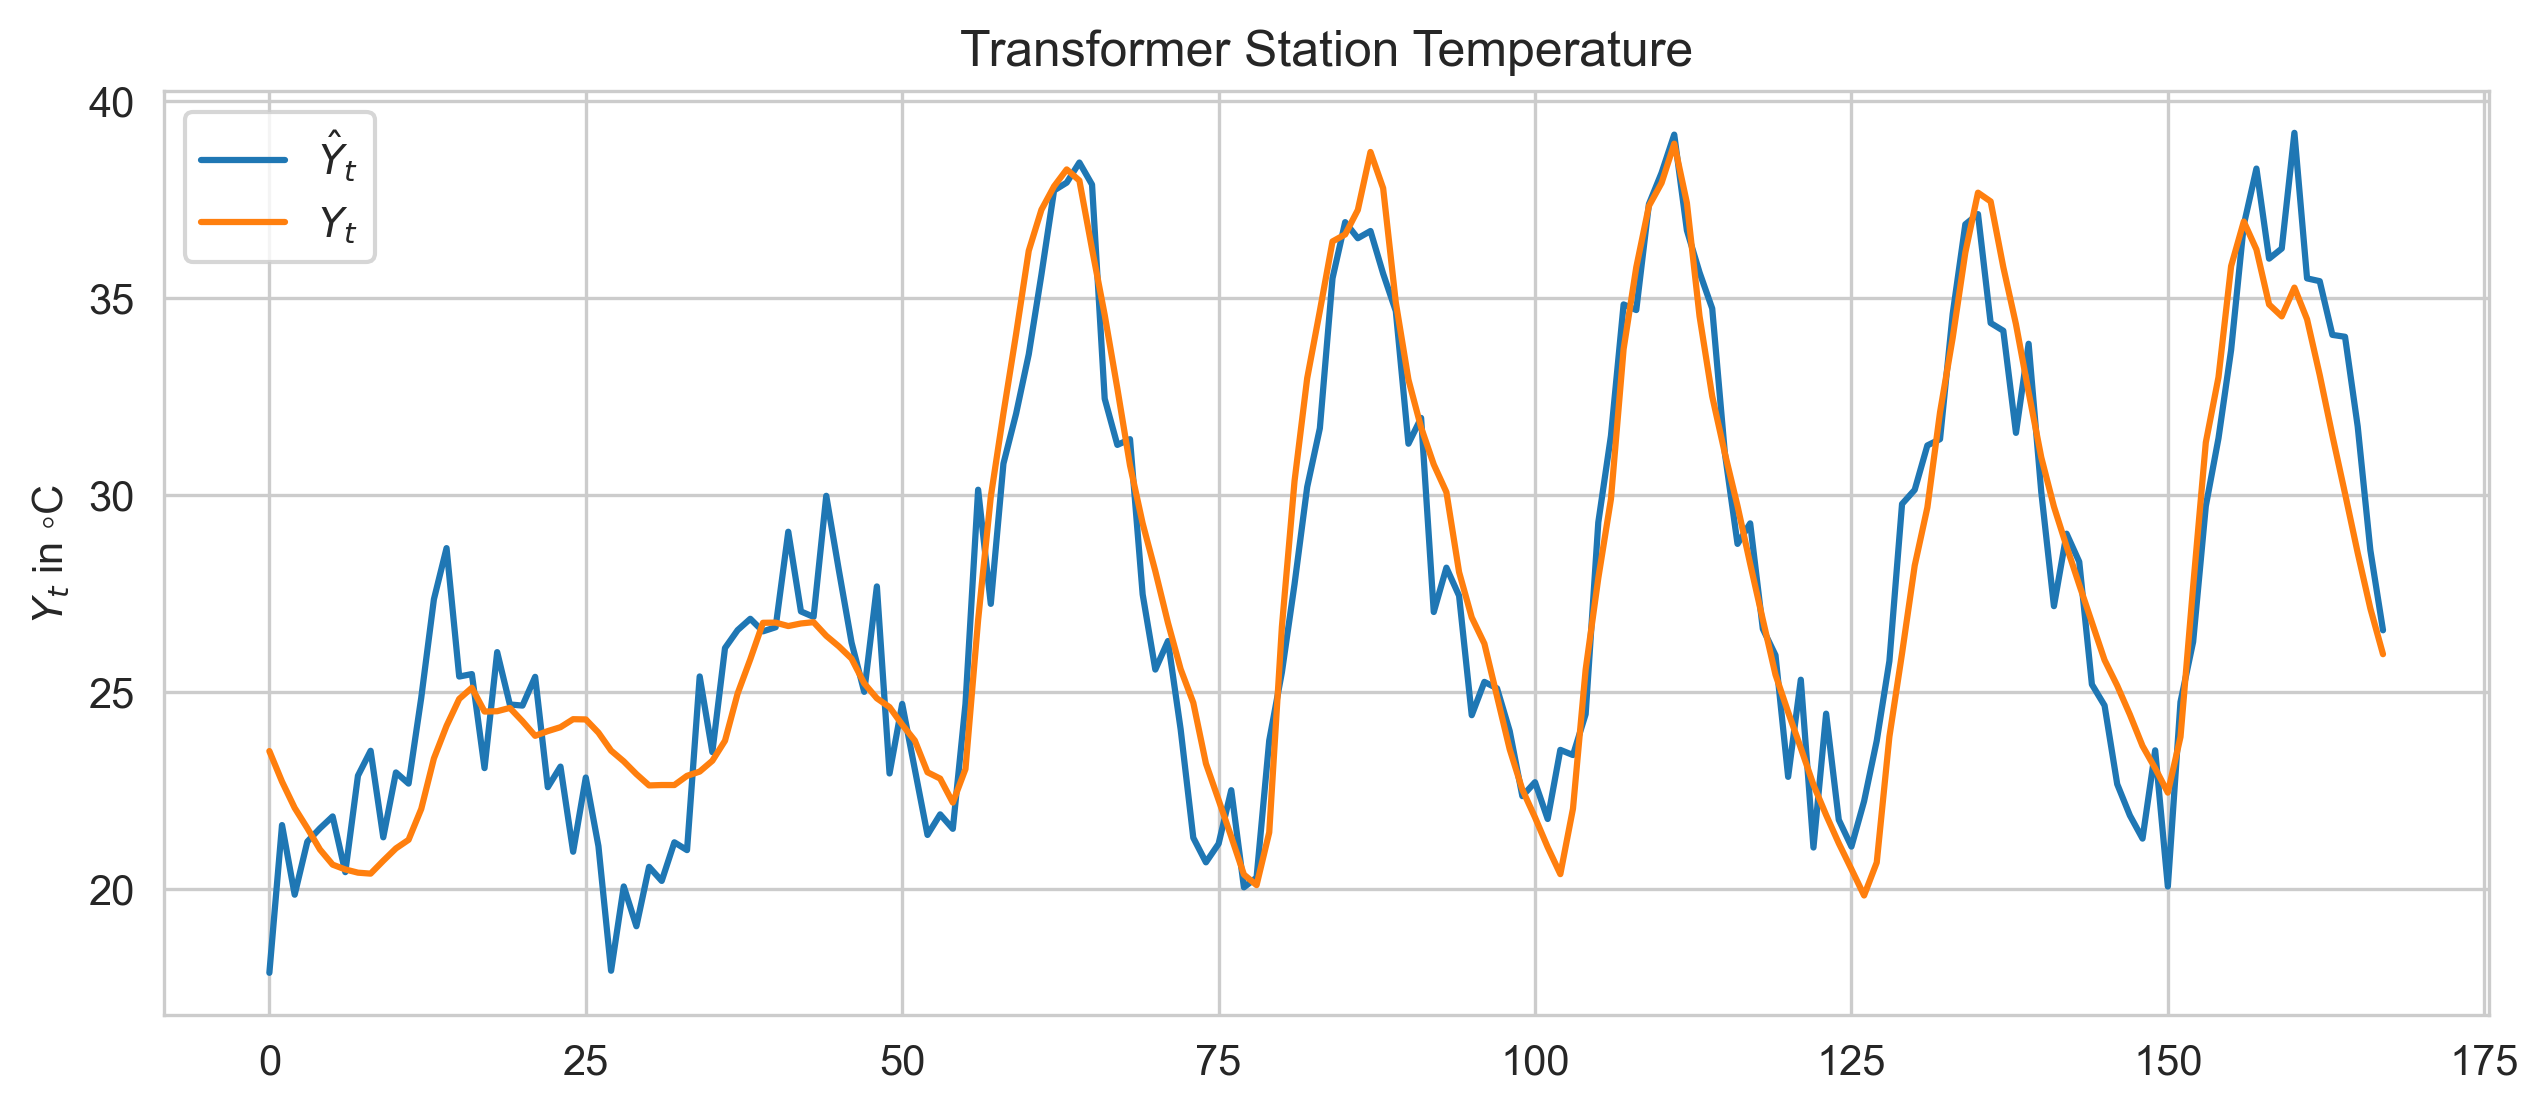

In [8]:
from project.ssm import estimate_2d_state_space, simulate_from_model_2d
from project.utils import plot_obervations
import pandas as pd
import numpy as np

df = pd.read_csv("transformer_data.csv")

# adheres to assignment4 tip; params in [-1,1], x0=20, w/o x0 estimation
res = estimate_2d_state_space(df)
y, x = simulate_from_model_2d(res.x, df)

plot_obervations(y, df)

In [2]:
# [[A, A], [A, A]], [[B, B, B], [B, B, B]], [C, C], sigma1, sigma2
res.x.round(4)

array([-8.3030e-01, -3.6050e-01,  6.8650e-01,  9.5430e-01, -1.7612e+00,
        1.1741e+00, -1.1408e+00,  9.1380e-01, -4.8930e-01,  8.1320e-01,
        2.6400e-01,  6.2540e-01,  1.0000e-03,  1.0000e-03])

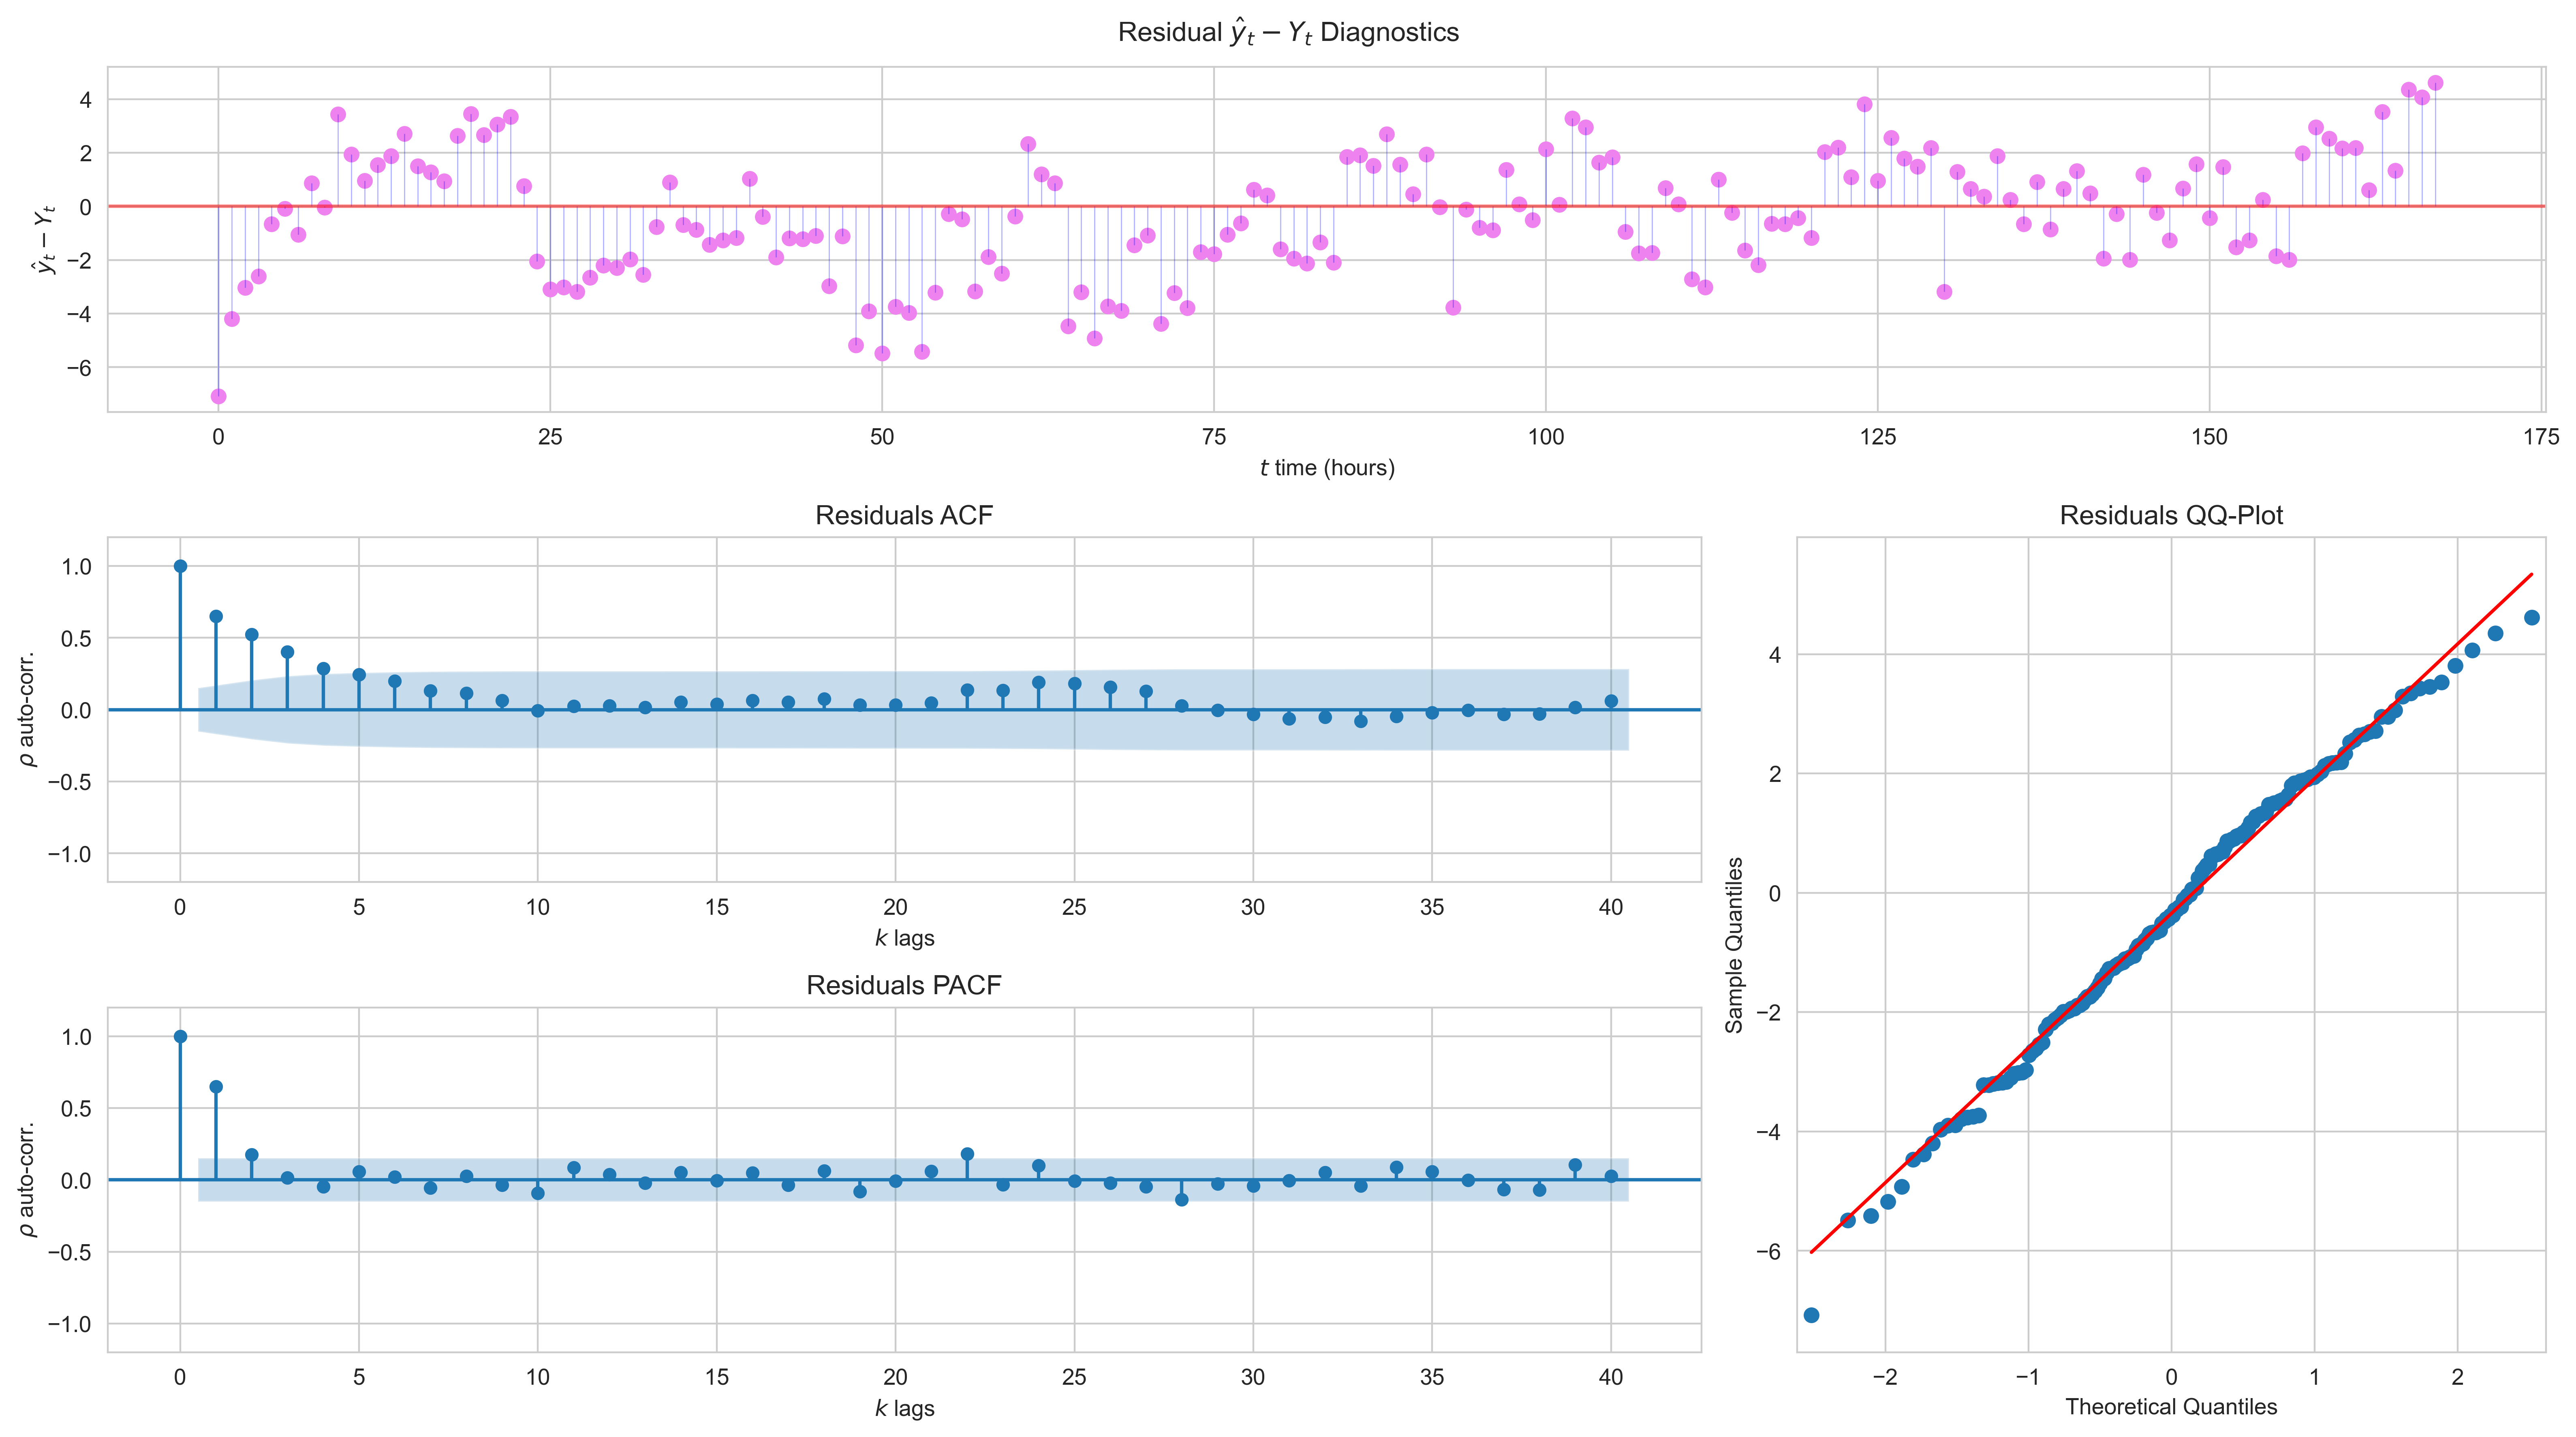

In [3]:
from project.utils import plot_residual_diagnostics

residuals = y - df["Y"].values
plot_residual_diagnostics(residuals)

In [4]:
from project.utils import compute_aic_bic
from project.ssm import kalman_loglik_2d

loglik = kalman_loglik_2d(res.x, df)
compute_aic_bic(-loglik, len(res.x), len(y))

(array([[499.23439197]]), array([[542.96988768]]))

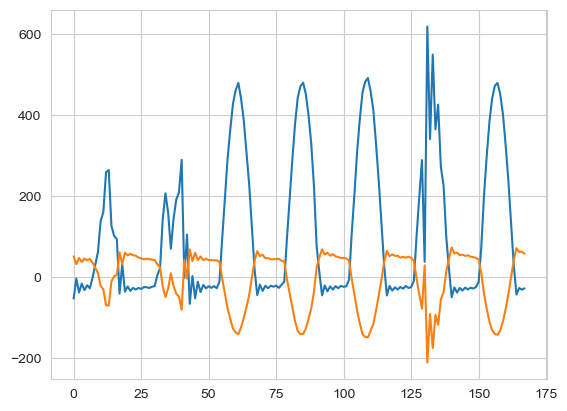

In [5]:
import matplotlib.pyplot as plt

# check the hidden states X_t
plt.plot(x)

#### Compare 2D vs 1D model

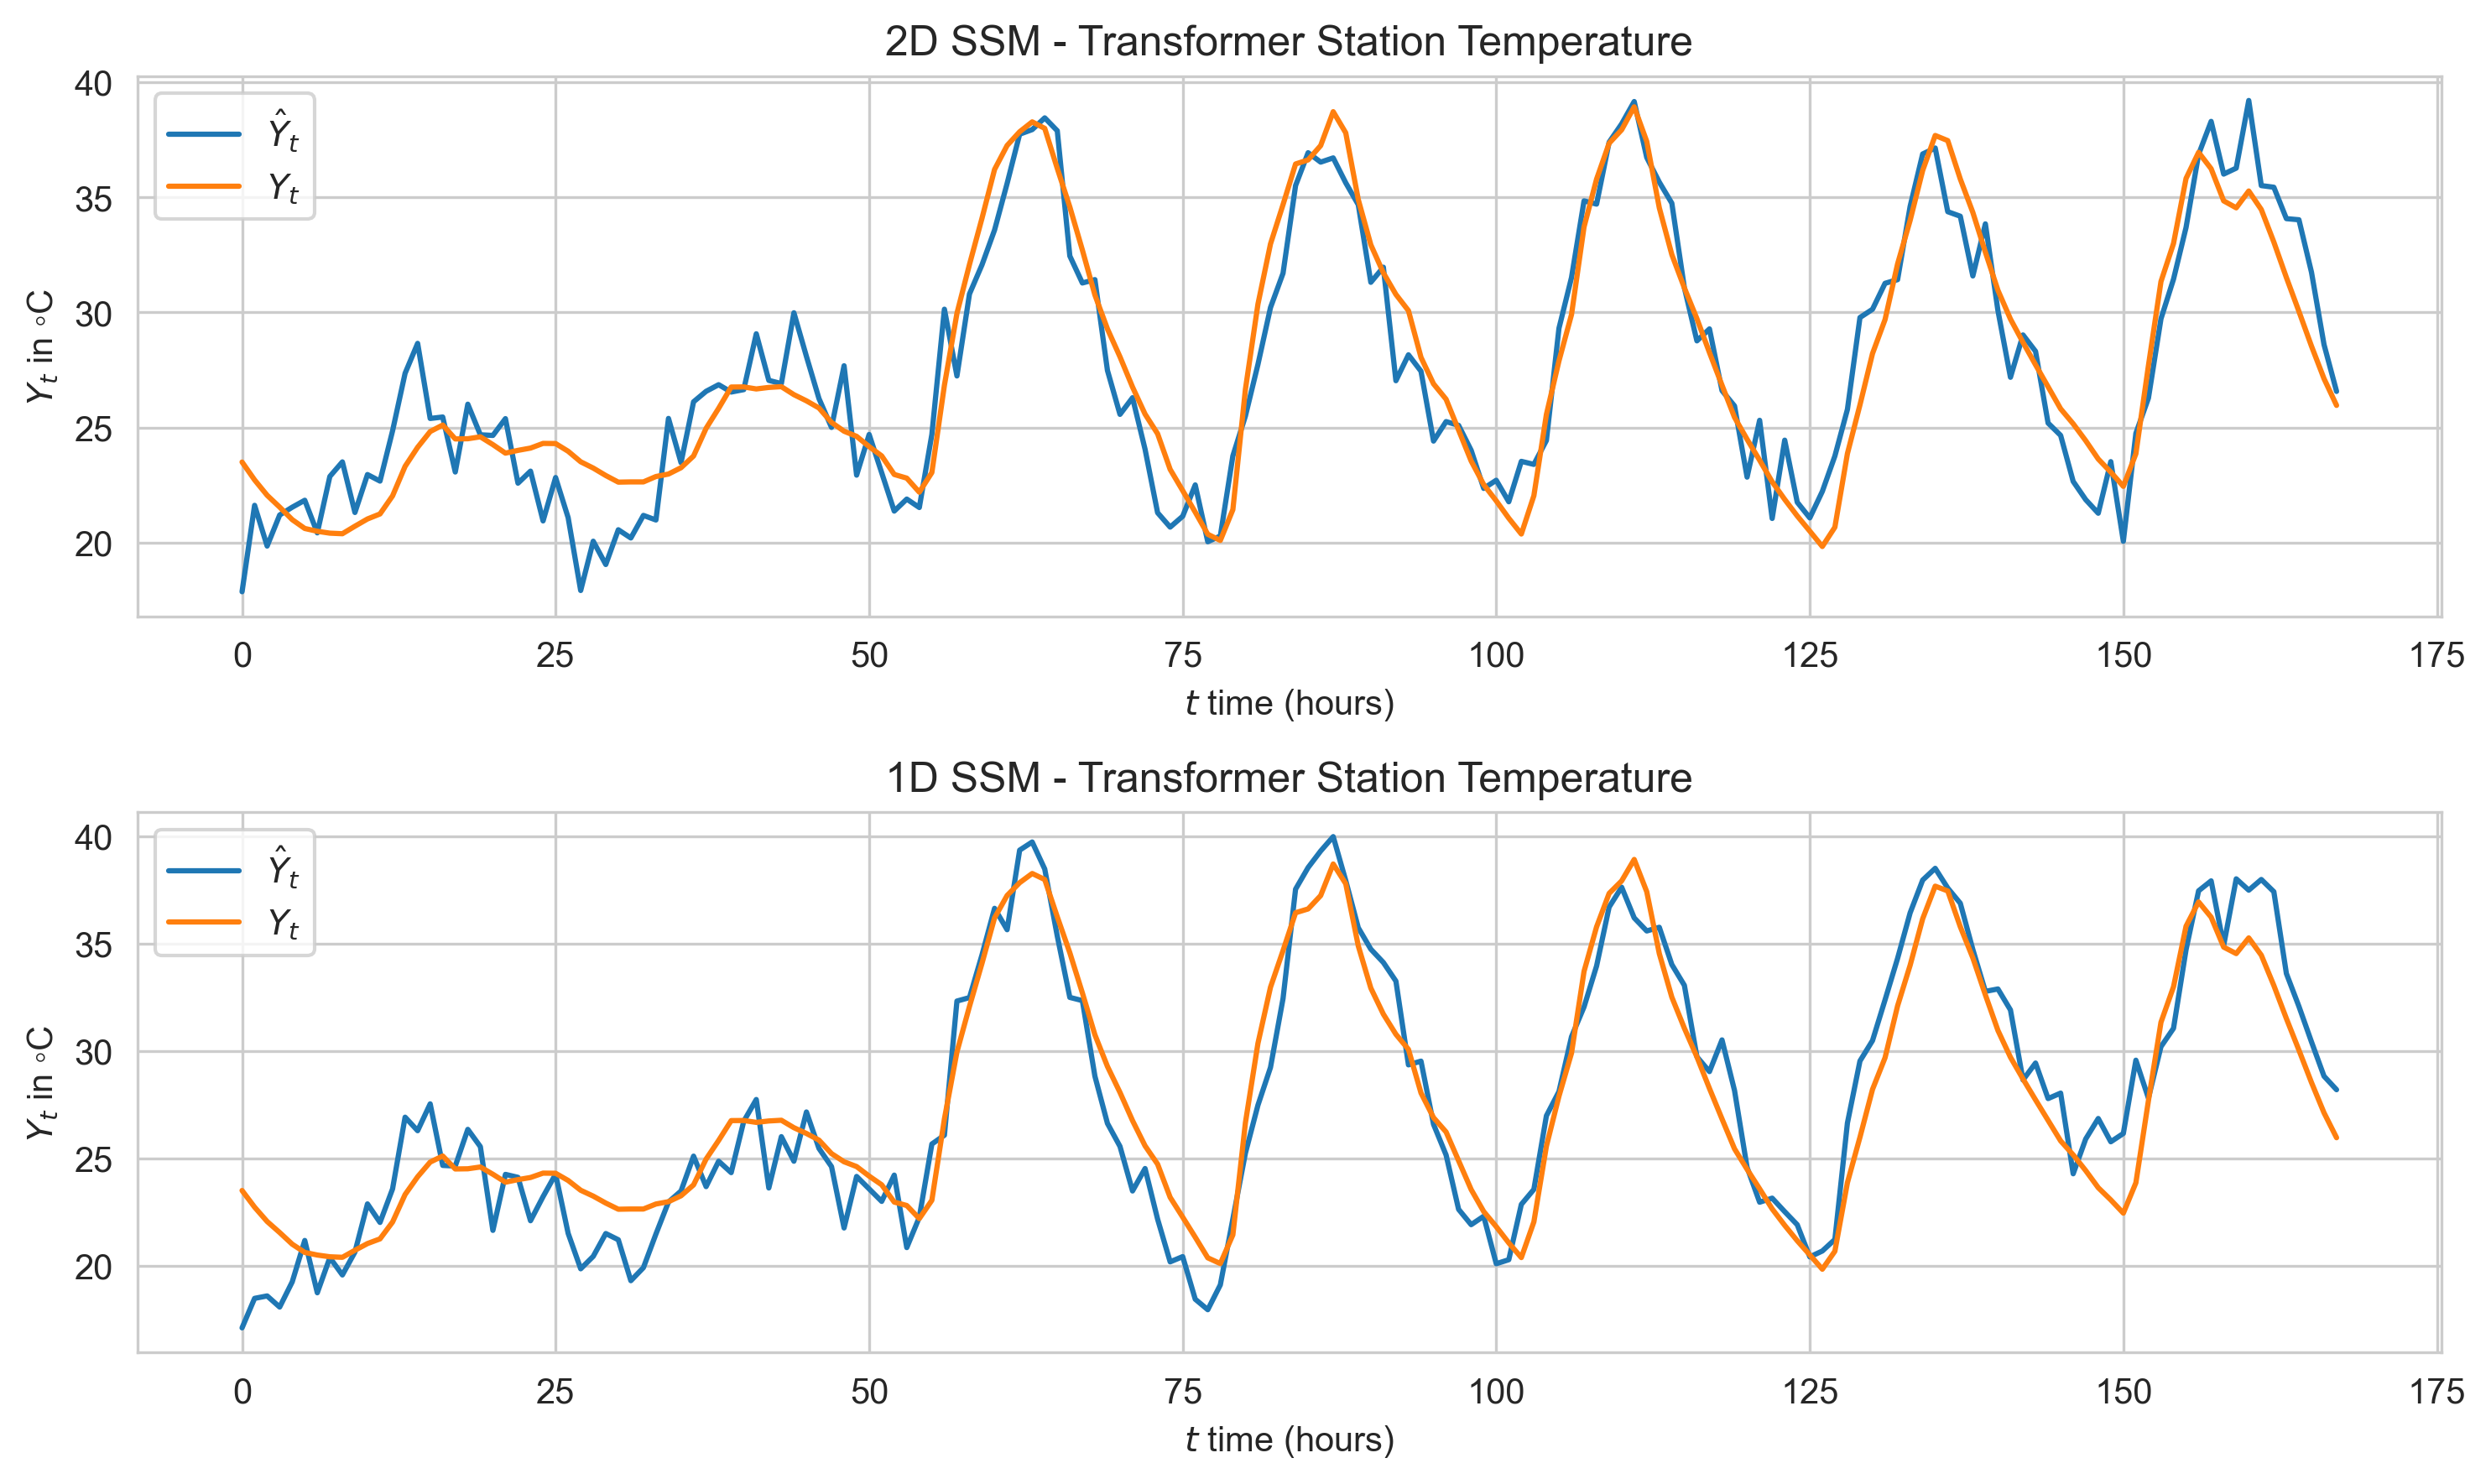

In [9]:
from project.ssm import estimate_1d_state_space, simulate_from_model_1d
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# comparison plot of 1D vs 2D model
plt.figure(figsize=(10,6), dpi=300)

plt.subplot(2,1,1)
plt.title("2D SSM - Transformer Station Temperature")
plt.plot(y, label="$\hat{Y}_t$")
plt.plot(df["Y"], label="$Y_t$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("$Y_t$ in ◦C")
plt.legend()

res = estimate_1d_state_space(df)
y, x = simulate_from_model_1d(res.x, df)
plt.subplot(2,1,2)
plt.title("1D SSM - Transformer Station Temperature")
plt.plot(y, label="$\hat{Y}_t$")
plt.plot(df["Y"], label="$Y_t$")
plt.xlabel("$t$ time (hours)")
plt.ylabel("$Y_t$ in ◦C")
plt.legend()

plt.tight_layout()

### 2.4

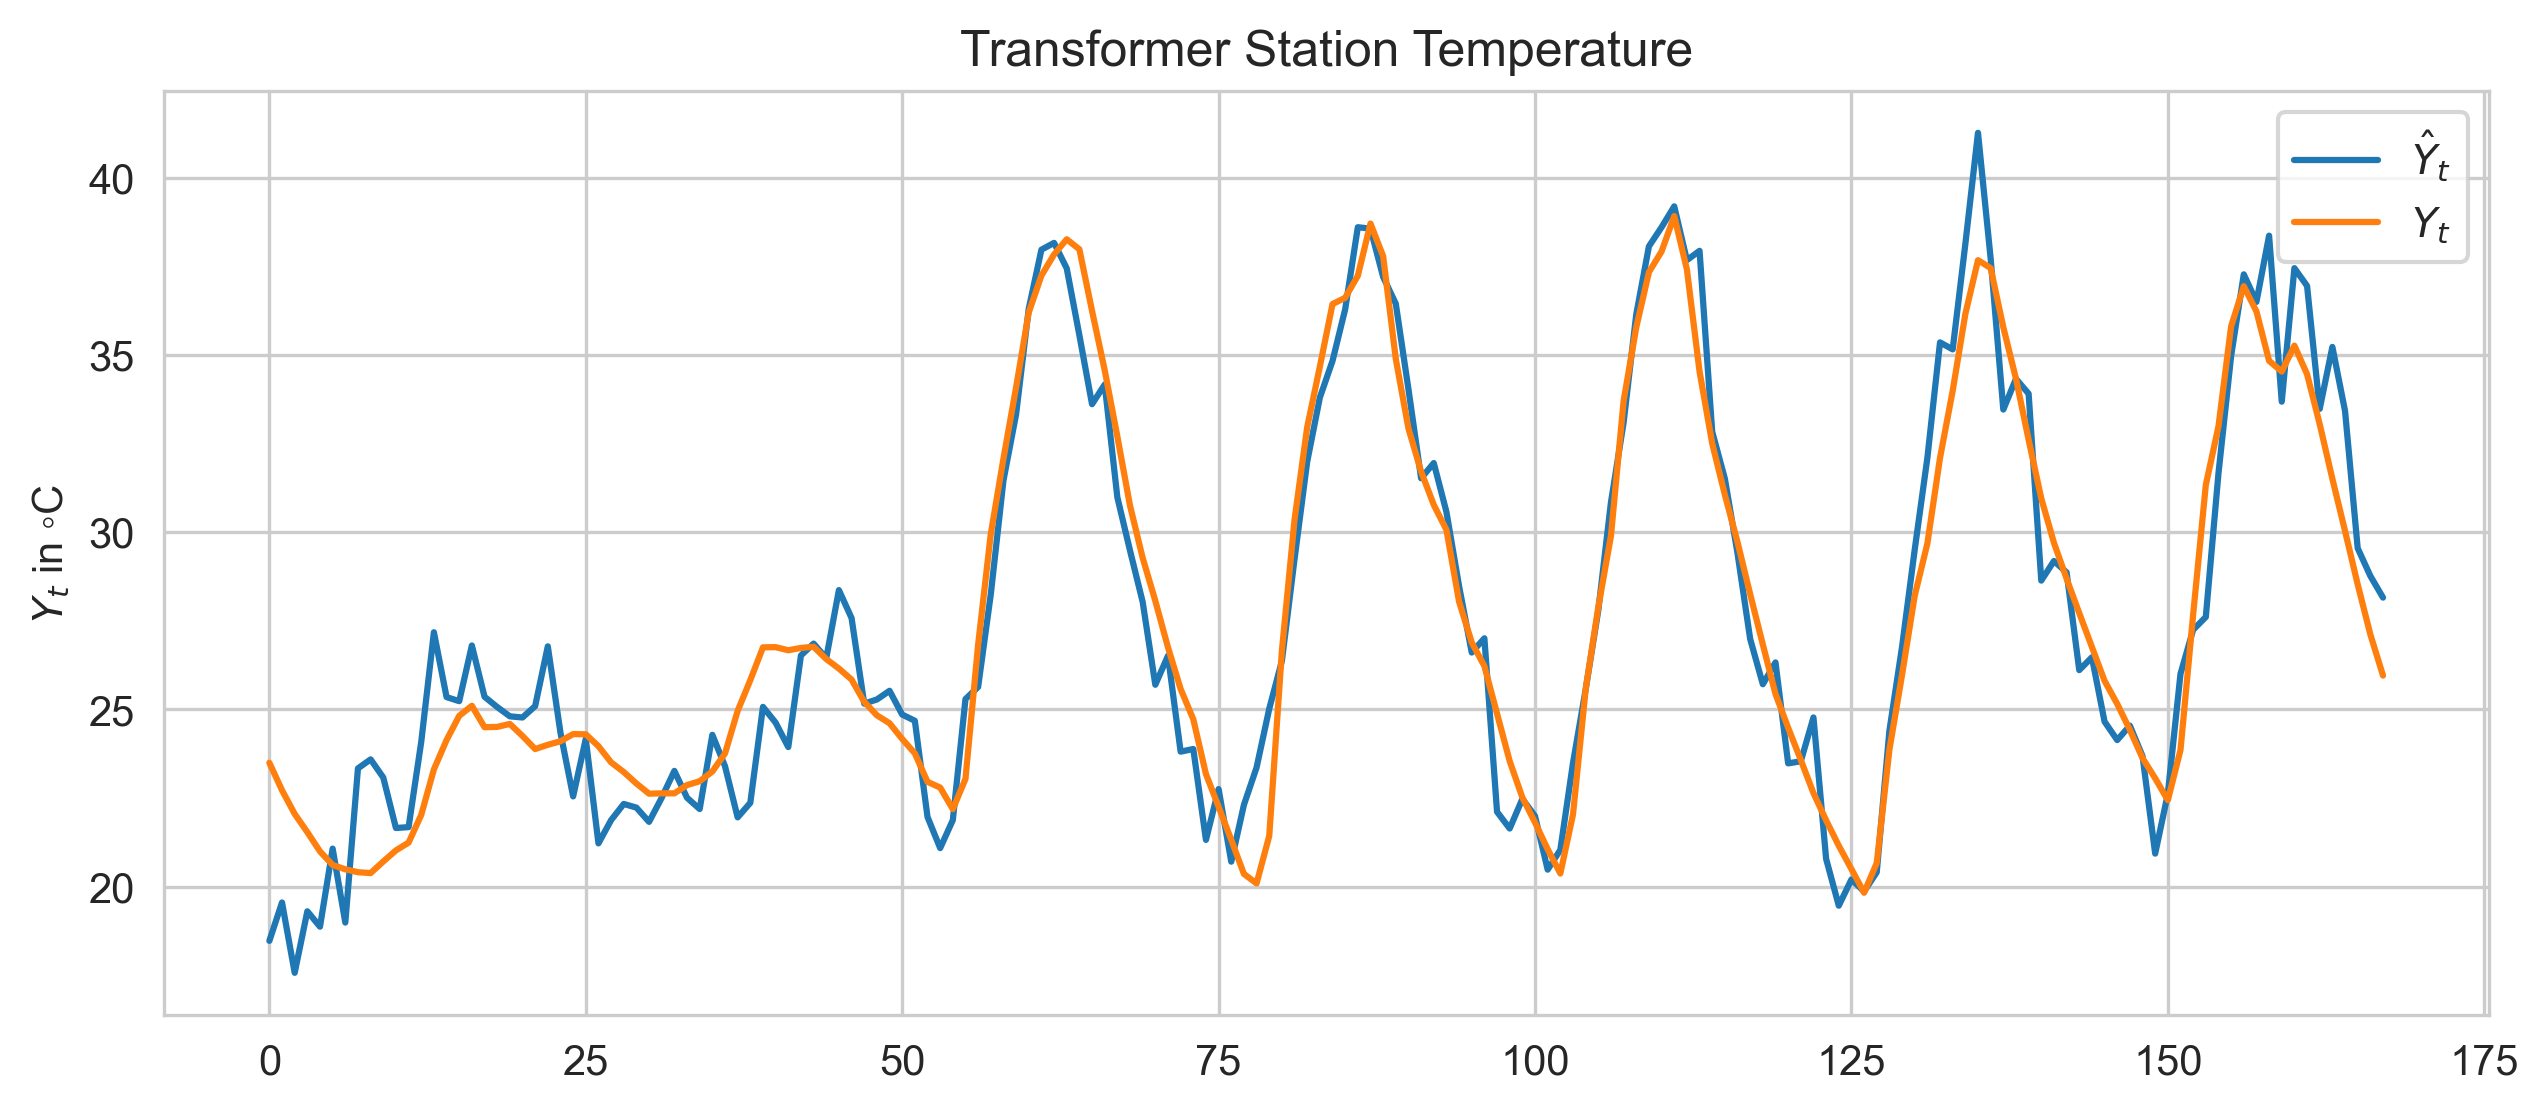

In [10]:
from project.ssm import estimate_2d_state_space, simulate_from_model_2d
from project.utils import plot_obervations
import pandas as pd
import numpy as np

df = pd.read_csv("transformer_data.csv")

# adheres to assignment4 tip; params in [-1,1], x0=20, w/o x0 estimation
res = estimate_2d_state_space(df)
y, x = simulate_from_model_2d(res.x, df)

plot_obervations(y, df)

array([-8.30299971e-01, -3.60514499e-01,  6.86477041e-01,  9.54279840e-01,
       -1.76120398e+00,  1.17409229e+00, -1.14084685e+00,  9.13810642e-01,
       -4.89264320e-01,  8.13162323e-01,  2.63961508e-01,  6.25418564e-01,
        1.00000000e-03,  1.00000000e-03])

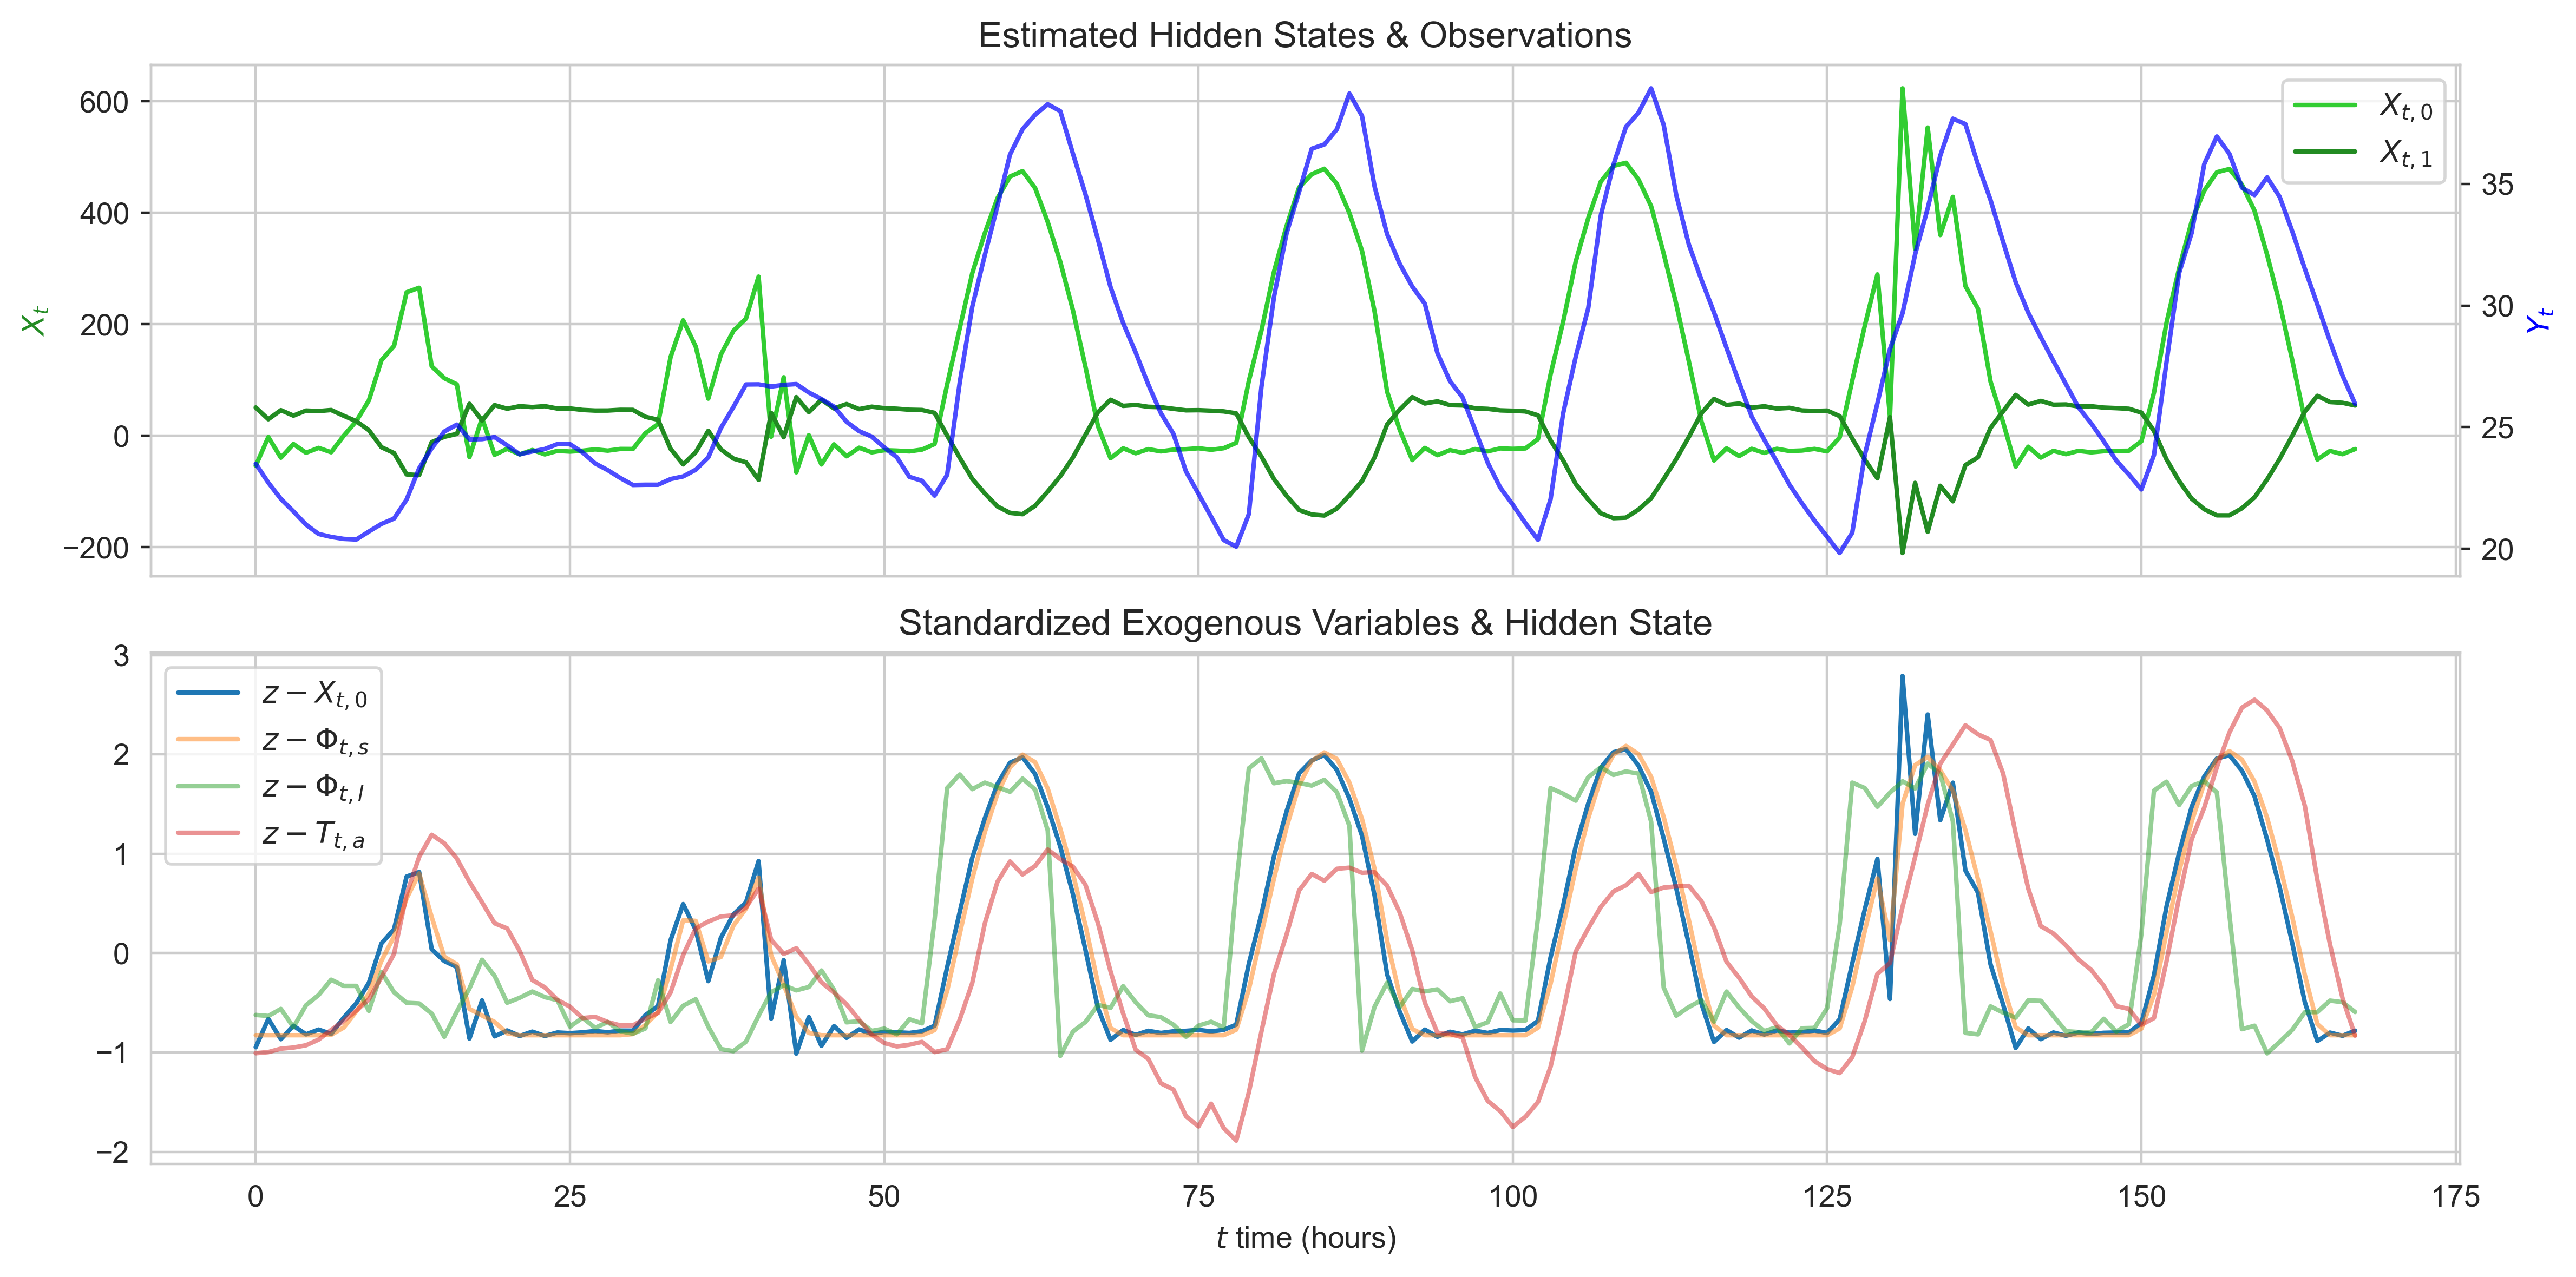

In [73]:
import numpy as np
import matplotlib.pyplot as plt

fig, [ax1, ax3] = plt.subplots(nrows=2, figsize=(12,6), dpi=400, sharex=True)

# plot hidden states X_t against exogenous variables
ax1.set_title("Estimated Hidden States & Observations")
ax1.plot(x[:,0], label="$X_{t,0}$", color='limegreen')
ax1.plot(x[:,1], label="$X_{t,1}$", color='forestgreen')
ax1.set_ylabel('$X_t$', color='forestgreen')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(df["Y"], label="$Y_t$", color='blue', alpha=0.7)
ax2.set_ylabel("$Y_t$", color='blue')
ax2.grid(False)

ax3.set_title("Standardized Exogenous Variables & Hidden State")
ax3.plot((x[:,0]-np.mean(x[:,0]))/np.std(x[:,0]), label="$z-X_{t,0}$")
ax3.plot((df["S"]-df["S"].mean())/df["S"].std(), label="$z-\Phi_{t,s}$", alpha=0.5)
ax3.plot((df["I"]-df["I"].mean())/df["I"].std(), label="$z-\Phi_{t,I}$", alpha=0.5)
ax3.plot((df["Ta"]-df["Ta"].mean())/df["Ta"].std(), label="$z-T_{t,a}$", alpha=0.5)
ax3.set_xlabel('$t$ time (hours)')
ax3.legend()

plt.tight_layout()

In [49]:
pd.concat([df[["Ta", "S", "I"]], pd.DataFrame(x)], axis=1).corr()

Ta         S         I         0         1
Ta  1.000000  0.712500  0.162654  0.636965 -0.590171
S   0.712500  1.000000  0.631766  0.979836 -0.965247
I   0.162654  0.631766  1.000000  0.681617 -0.691177
0   0.636965  0.979836  0.681617  1.000000 -0.996138
1  -0.590171 -0.965247 -0.691177 -0.996138  1.000000

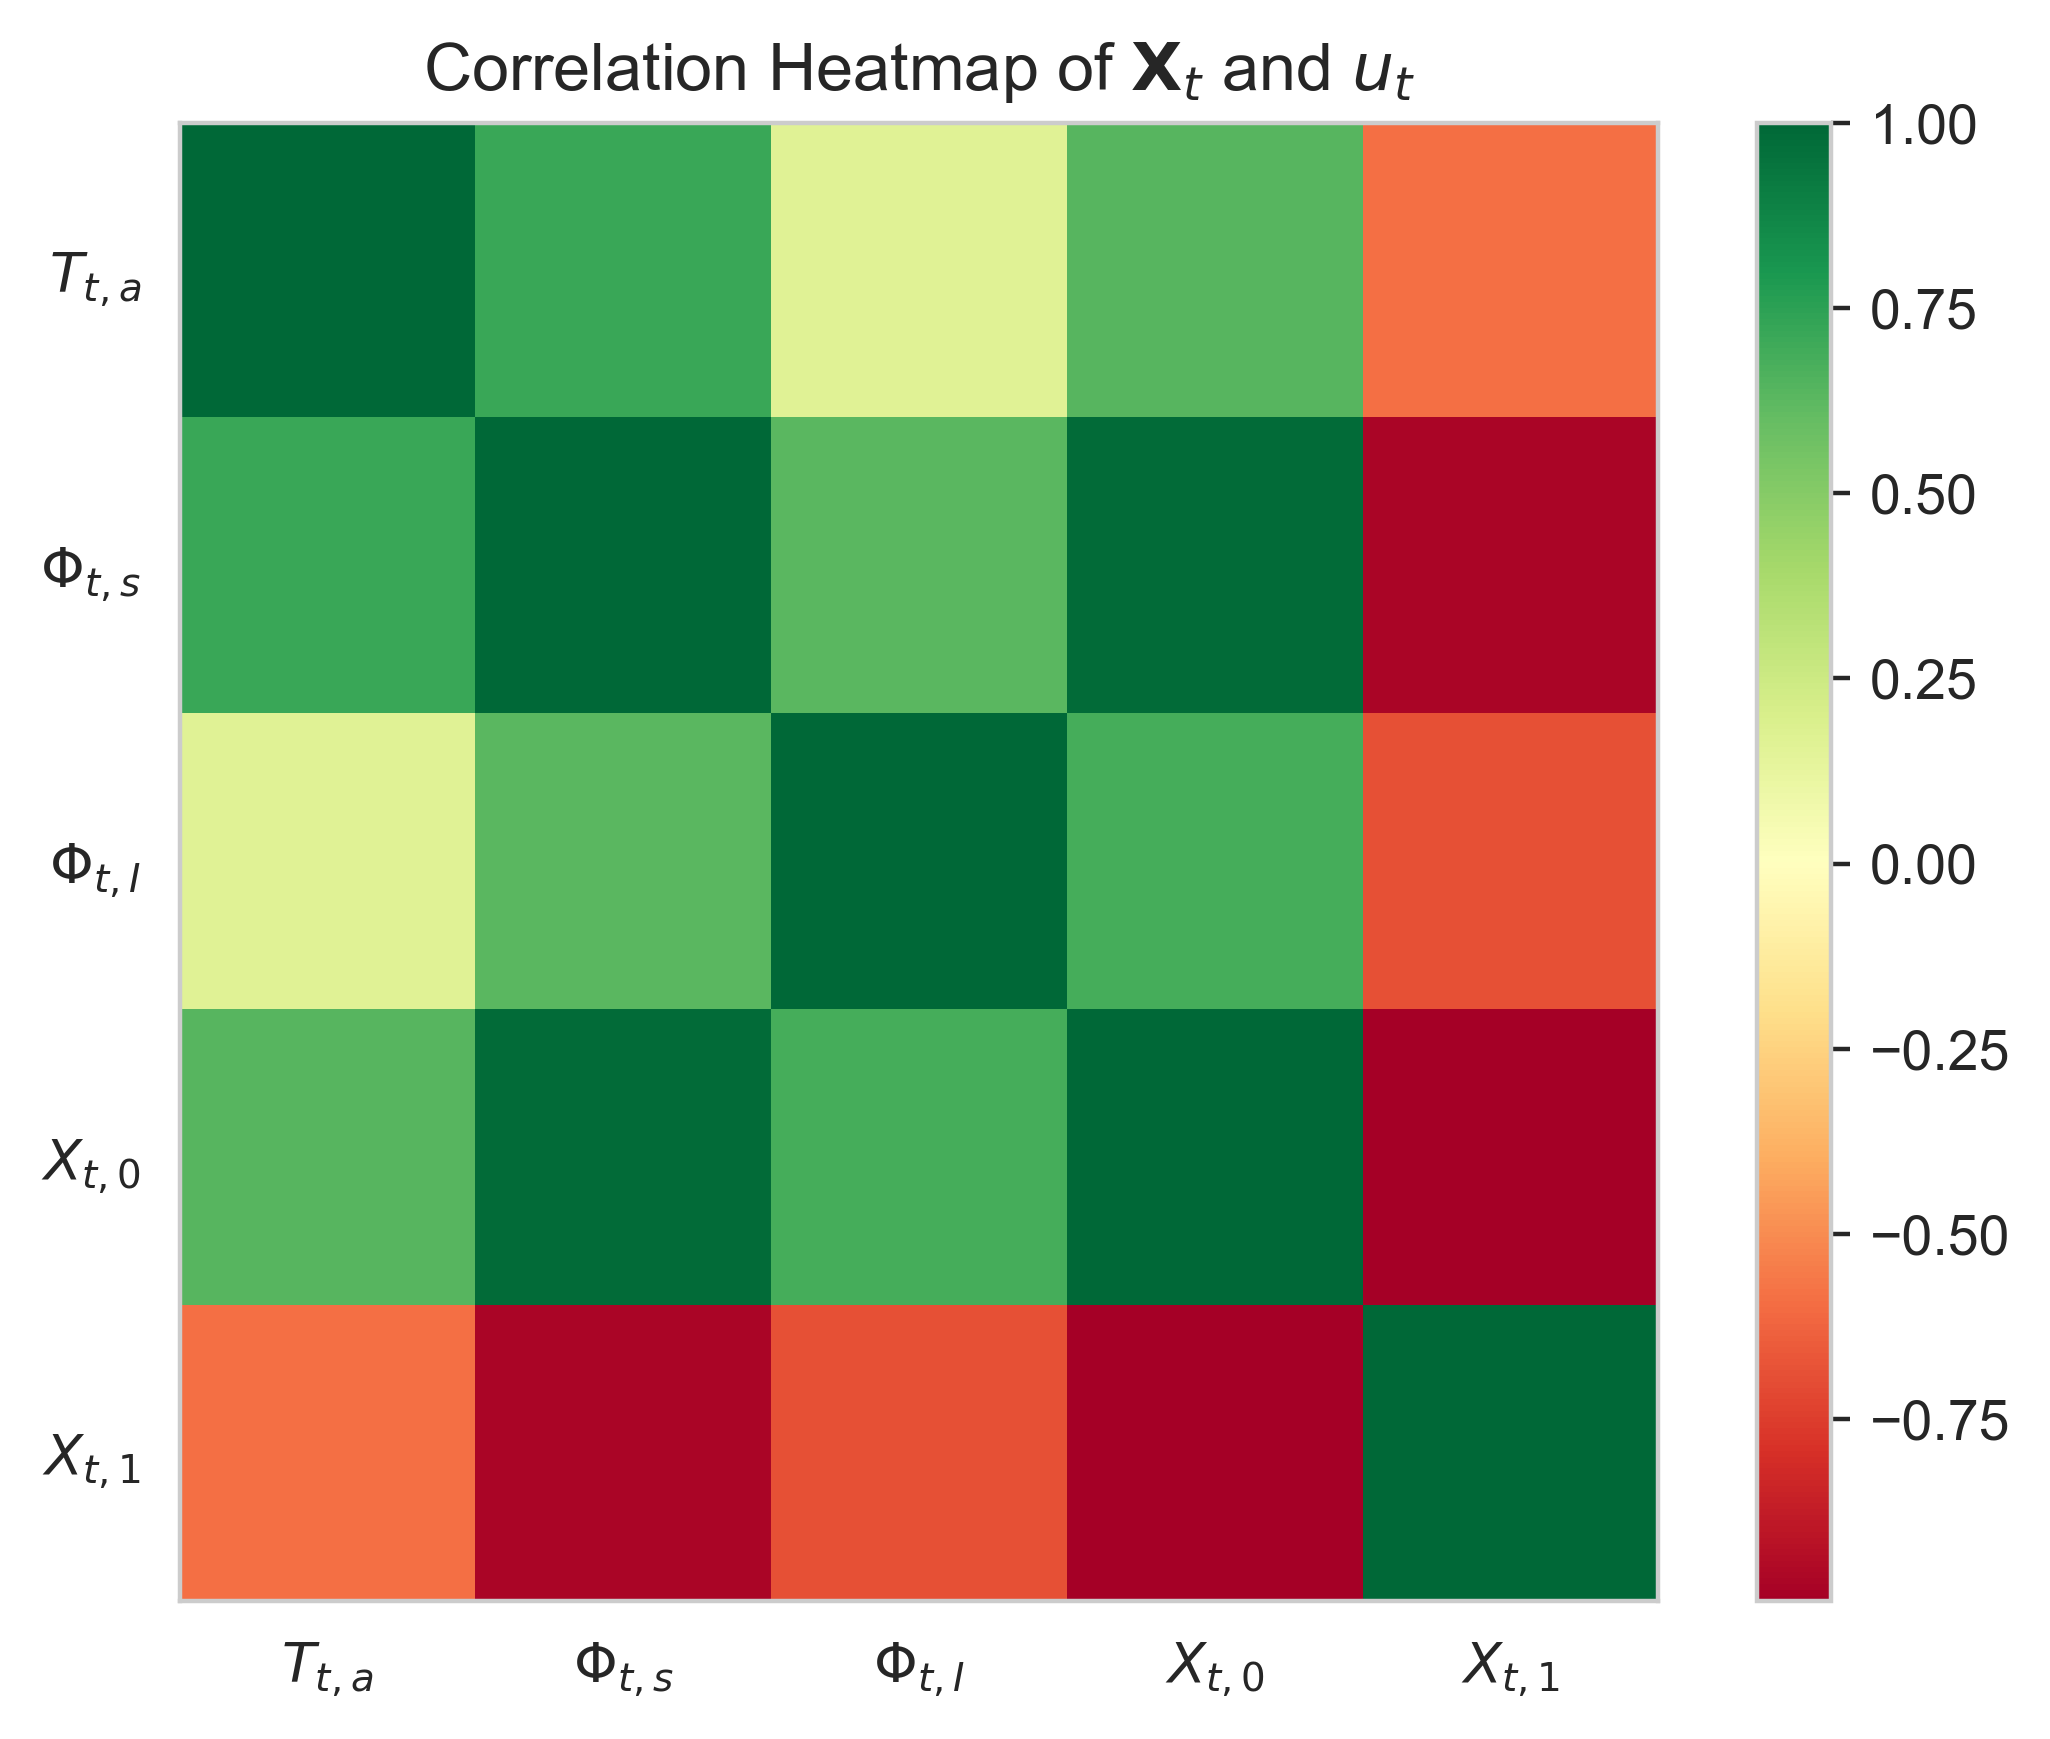

In [72]:
plt.figure(dpi=400)
plt.title("Correlation Heatmap of $\mathbf{X}_t$ and $u_t$")
plt.imshow(pd.concat([df[["Ta", "S", "I"]], pd.DataFrame(x)], axis=1).corr(), cmap='RdYlGn')
plt.xticks(ticks=np.arange(5), labels=["$T_{t,a}$", "$\Phi_{t,s}$", "$\Phi_{t,I}$", "$X_{t,0}$", "$X_{t,1}$"])
plt.yticks(ticks=np.arange(5), labels=["$T_{t,a}$", "$\Phi_{t,s}$", "$\Phi_{t,I}$", "$X_{t,0}$", "$X_{t,1}$"])
plt.grid(False)
plt.colorbar()

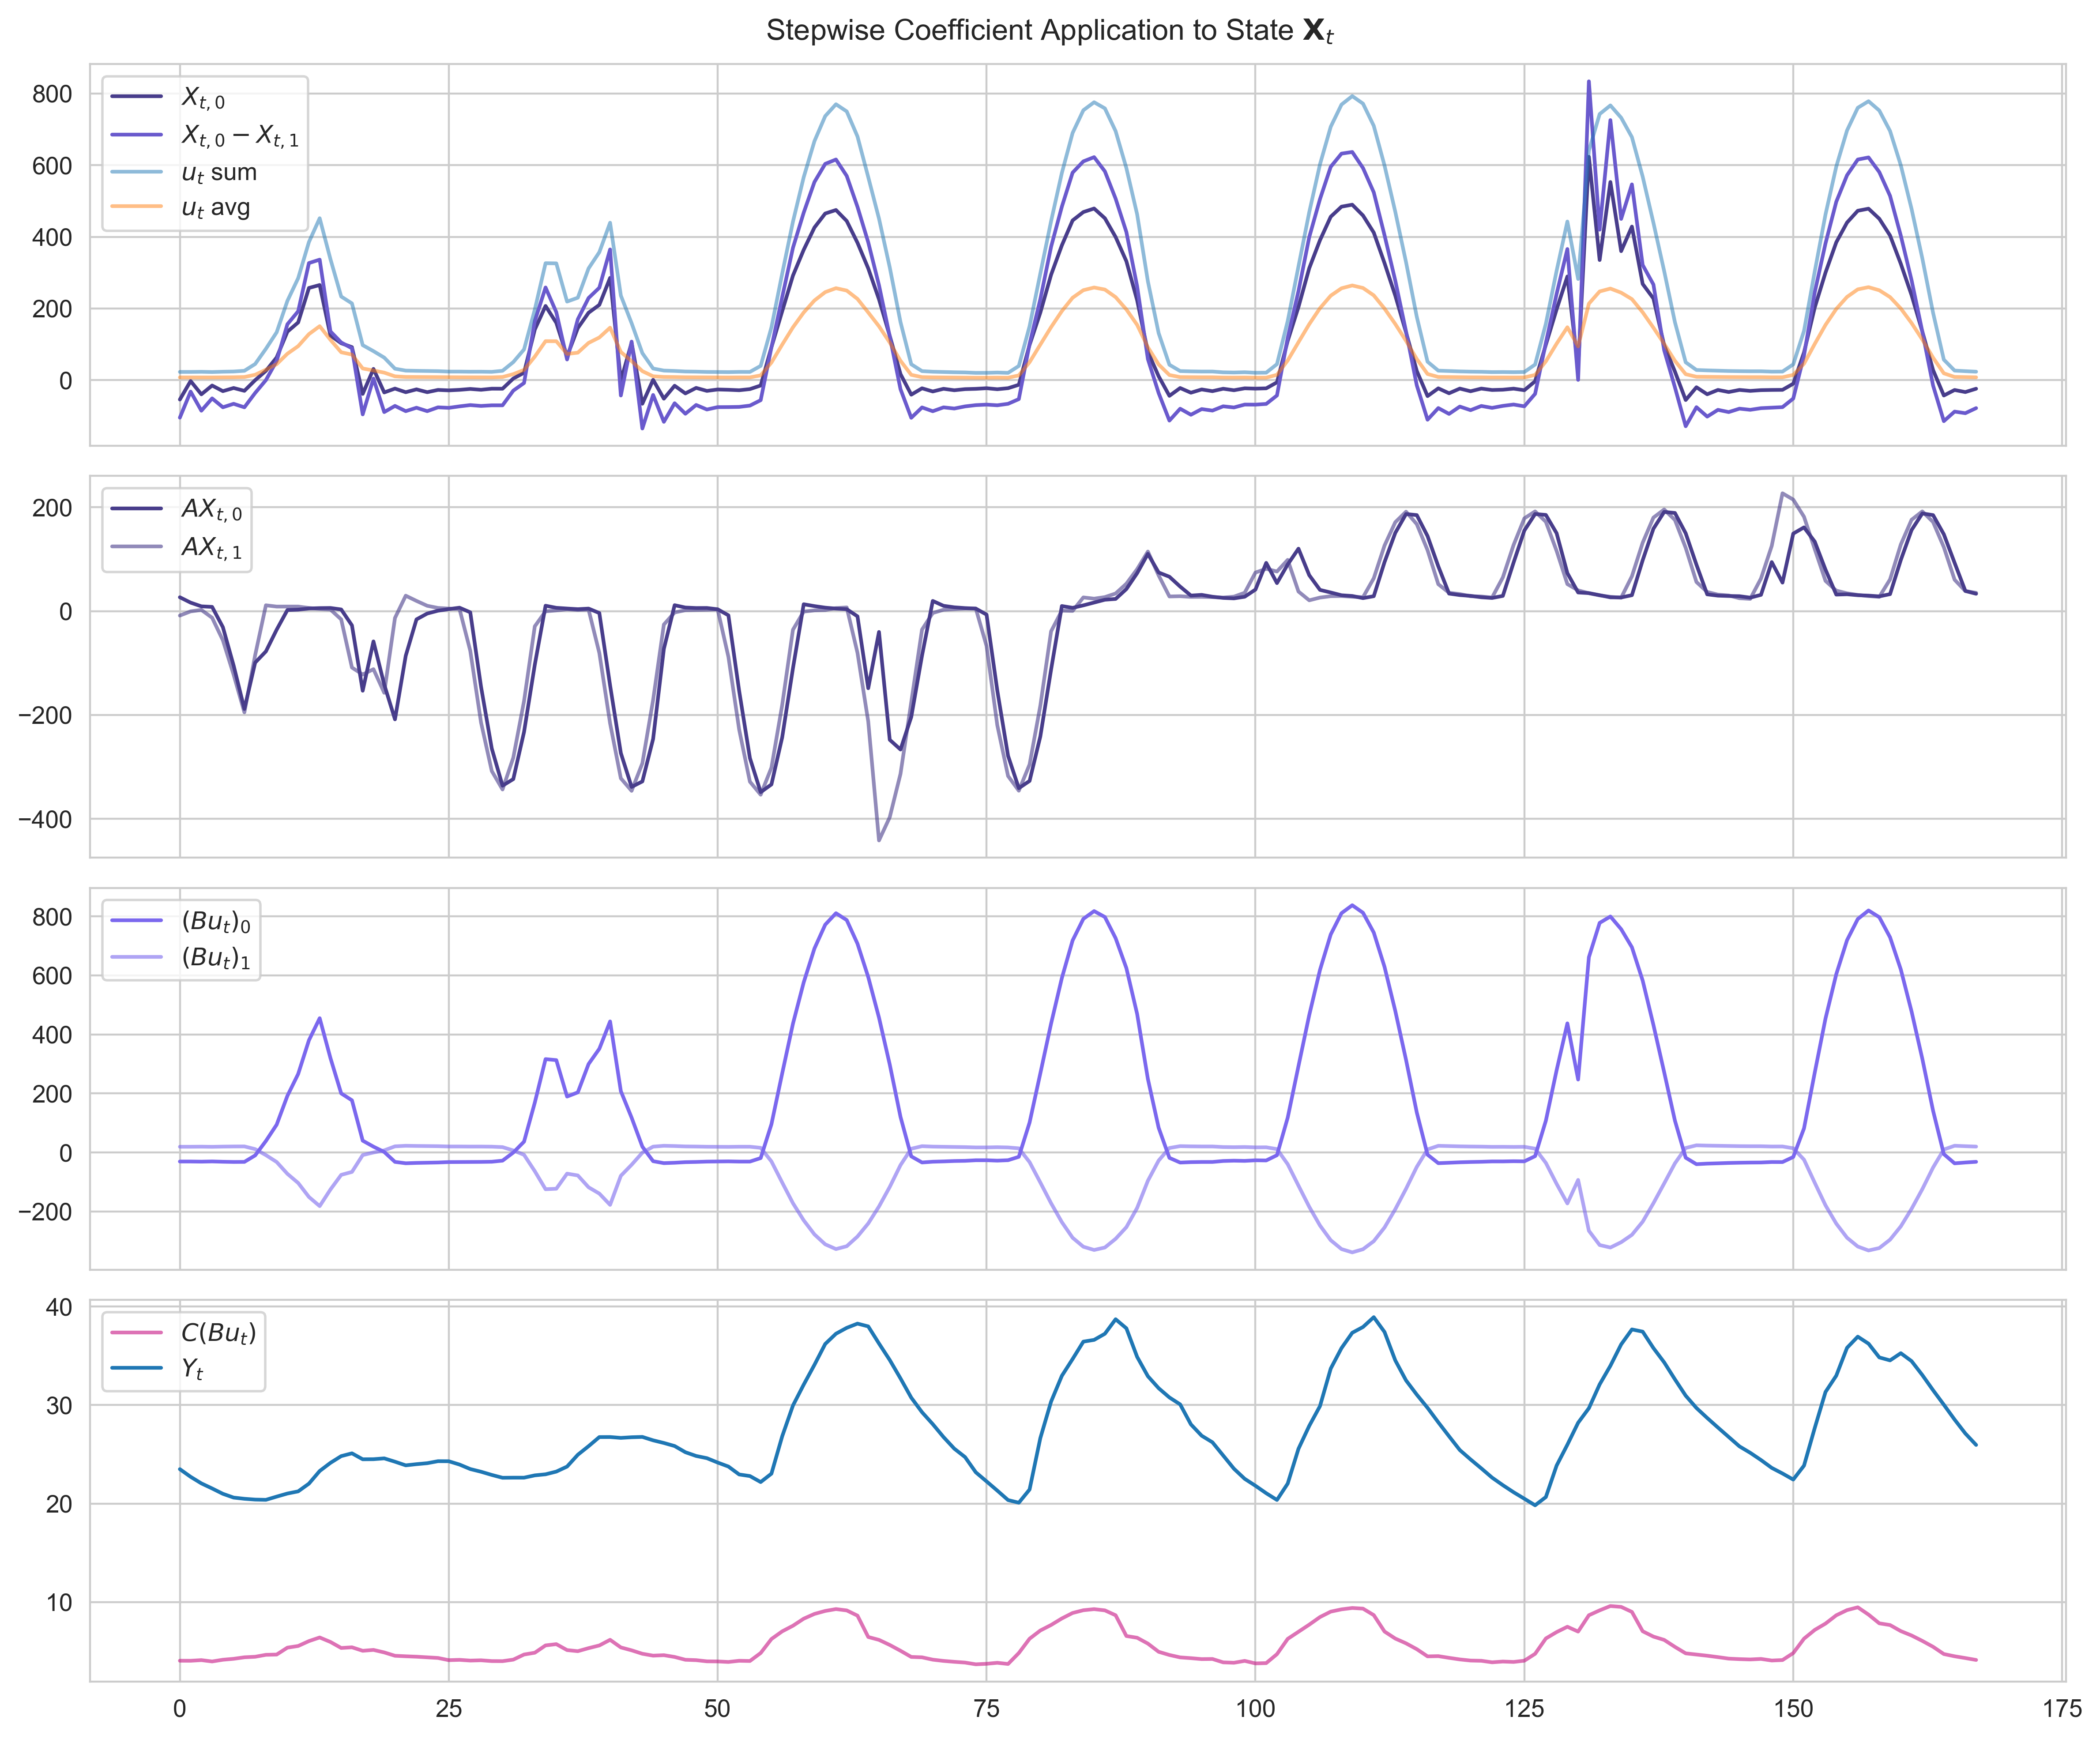

In [74]:
import numpy as np
import matplotlib.pyplot as plt

A = res.x[:4].reshape(2,2)
B = res.x[4:10].reshape(2,3)
C = res.x[10:12].reshape(1,2)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(nrows=4, figsize=(12,10), dpi=400, sharex=True)
fig.suptitle("Stepwise Coefficient Application to State $\mathbf{X}_t$")

ax1.plot(x[:,0], label="$X_{t,0}$", c='darkslateblue')
ax1.plot(x[:,0]-x[:,1], label="$X_{t,0} - X_{t,1}$", c='slateblue')
ax1.plot(df["S"]+df["I"]+df["Ta"], label="$u_t$ sum", alpha=0.5)
ax1.plot((df["S"]+df["I"]+df["Ta"])/3, label="$u_t$ avg", alpha=0.5)
ax1.legend()

AXt = (A@x.T).reshape(-1,2)
ax2.plot(AXt[:,0], label="$AX_{t,0}$", c='darkslateblue')
ax2.plot(AXt[:,1], label="$AX_{t,1}$", c='darkslateblue', alpha=0.6)
ax2.legend()

But = B@df[["Ta", "S", "I"]].values.T
ax3.plot(But[0,:], label="$(B u_t)_0$", c='mediumslateblue')
ax3.plot(But[1,:], label="$(B u_t)_1$", c='mediumslateblue', alpha=0.6)
ax3.legend()

CBut = (C@But).reshape(-1,)
ax4.plot(CBut, label="$C (B u_t)$", c='mediumvioletred', alpha=0.6)
ax4.plot(df["Y"], label="$Y_t$")
ax4.legend(loc='upper left')

plt.tight_layout()

In [64]:
(A@x.T).shape

(2, 168)

*Conclusion:*

- no optimization and 1-initialized leads to avg of exogenous $u_t$ as state vectors $X_t$ (+/- a little noise)
- of course with correct parameter values A, B, C, D, sigma1, sigma2 initialized, it becomes an accurate reconstruction

**Interpretation Guidance:**

* Plot $X_{1,t}$, $X_{2,t}$ vs. time and against inputs $Ta_t, \Phi_{s,t}, \Phi_{I,t}$
* Analyze:

  * Does one state correlate with load?
  * Does one act as a lagging “thermal buffer”?
* Check sign/magnitude of **B** matrix to infer effect of each input


**Experiment:**

If all parameters are set to 1.

_________